In [1]:
#Importing relevant packages 

import numpy as np
import pandas as pd
from datetime import datetime #To check start and end time when running code
from tqdm import tqdm #This is for creating progress bars.
import logging #This is to provide logging of information when running the LDA
import sys #This is to disable logging when it's no longer needed
import pickle #To store and open previously saved machine learning models 

#Importing NLTK and NLP packages
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore


# TOPIC MODELLING 

In this lab, we will apply a 50-topic LDA model to tweets from US Members of Congress to examine discussions about COVID-19 by Democrats and Republicans over time. Who was quicker to set the agenda around COVID-19, Democrats or Republicans? Make a guess if you know something about US politics.

The dataset is similar to last week's scaling lab and has been preprocessed similarly, with the main exception being that this time tweets are subsetted from 2019 and later, because we are mainly interested in tweets that (may) capture the COVID-19 crisis. The preprocessed dataset is called 'MOCTweets_preprocessed.csv'. 

#### If you wish to replicate the preprocessing, these are the steps taken for this dataset:

1. Changing 'date' from str type object to datetime type 
2. Subsetting to 2019 and later 
3. Removing unneeded columns (all except 'date', 'text', 'affiliation', and 'nominate_name')
2. Removing duplicated tweets 
7. Turning independents into Democrats or Republicans. In essence, finding the independents ("SANDERS, Bernard" and "KING, Angus Stanley, Jr.") and turning these to "Democrat". 
7. Removing instances of "&amp"
8. Replacing all remaining "&" with "and"
8. Removing odd special characters that show up in topic model ("┻","┃","━","┳","┓","┏","┛")
9. There are some annoying cases in these data where a character that looks like a space is not a space. Here, we just replace that character with an actual space. Replacing "\u202F", "\u2069", "\u200d", and "\u2066" with " ".
6. Removing "RT" and "via"
11. Removing mentions (@someone)
10. Removing numbers, removing punctuation (except hyphens and #), removing separators, removing urls, lowercasing, removing stopwords, lemmatizing, and stemming.


In [2]:
#Importing and viewing data
tweets = pd.read_csv("MOC_Tweets.csv")
tweets.head(3)

,Unnamed: 0,user_id,num_tweets,raw_url,url,url_tweet_part,tweet_type,date,tweet_id,retries,text_user_id,text,geography,affiliation,nominate_name
0,1,5558312.0,430143,none,none,none,authored,20190319,1.108000e+18,999999,5558312.0,Federal government employees are dedicated pub...,AR,Republican,"BOOZMAN, John"
1,2,5558312.0,430143,none,none,none,authored,20170803,8.929066e+17,999999,5558312.0,Congrats to @SenTomCotton's Sand Lizards on th...,AR,Republican,"BOOZMAN, John"
2,3,5558312.0,430143,https://twitter.com/60Minutes/status/656077372...,https://twitter.com/60Minutes/status/656077372...,author,quote,20151019,6.560929e+17,0,5558312.0,WATCH: I applaud Northeast #Arkansas residents...,AR,Republican,"BOOZMAN, John"


In [3]:
#Checking dataset shape
tweets.shape

(1615238, 15)

In [4]:
#Change date from str object to datetime object
tweets['date'] = pd.to_datetime(tweets['date'], format = '%Y%m%d', errors = 'ignore')


In [5]:
#Subsetting the data to span 2019 and later 
tweets = tweets.loc[tweets.date > datetime(2018,12,31)]

#Checking new dataset shape
tweets.shape


(585744, 15)

In [6]:
#Removing duplicated tweets 
tweets = tweets.drop_duplicates(subset = 'tweet_id')

#Checking new dataset shape 
tweets.shape

(579820, 15)

In [7]:
#Redefining dataset to only include useful columns 
tweets = tweets[['date','text','affiliation','nominate_name']]


In [8]:
#Locating politicians marked as 'Independent' affiliation and turning these into Democrats

print(tweets.loc[tweets.affiliation == 'Independent']['nominate_name'].value_counts())

tweets['affiliation'] = tweets['affiliation'].apply(lambda x: 'Democrat' if x == 'Independent' else x)


SANDERS, Bernard            1512
KING, Angus Stanley, Jr.     557
Name: nominate_name, dtype: int64


In [9]:
#Check if all 'Independent' were converted. Looks like it. 
print(tweets.affiliation.value_counts())

Democrat      371662
Republican    208158
Name: affiliation, dtype: int64


In [10]:
#Reusing and tweaking the function for preprocessing from last week to fit specifics of this dataset.

def preprocess(text):
    
    #Lowercasing words
    text = text.lower()
    
    #Removing '&amp' which was found to be common
    text = re.sub(r'&amp','', text)
    
    #Replace other instances of "&" with "and"
    text = re.sub(r'&','and', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)
    
    #Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\b\W*@\w+)+): ', '', text)
    
    #Removing punctuation
    
    my_punctuation = string.punctuation.replace('#','')
    my_punctuation = my_punctuation.replace('-','')
    
    text = text.translate(str.maketrans('', '', my_punctuation))
    text = re.sub(r' - ','', text) #removing dash lines bounded by whitespace (and therefore not part of a word)
    text = re.sub(r'[’“”—,!]','',text) #removing punctuation that is not captured by string.punctuation
    
    #Removing odd special characters
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(r' +',' ',text)
    
    #Tokenizing
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens
    

def preprocess_lemma(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    tokens = text_lemmatized

    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in tokens if i not in stop_words_list])
    
    return text

def preprocess_stem(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens = [i for i in tokens if i not in stop_words_list]
    
    #Stemming
    stemmer = nltk.PorterStemmer()    #Creating stemmer
    sent_stemmed = []                 #Empty list to save stemmed sentence
    
    for word in tokens:
        stem = stemmer.stem(word)     #Stemming words
        sent_stemmed.append(stem)
        
    tokens = sent_stemmed
    
    return " ".join(tokens)


In [ ]:
#Preprocessing and lemmatizing (takes approx. 10 mins)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing begun.") #Printing start time

tqdm.pandas() #Getting a progress bar. Use progress_apply instead of apply.
tweets['text_lemma'] = tweets['text'].progress_apply(lambda x: preprocess_lemma(x))

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing completed.") #Printing end time


In [ ]:
#Preprocessing and stemming (takes approx. 5 mins)

tweets['text_stemmed'] = tweets['text'].progress_apply(lambda x: preprocess_stem(x))


In [ ]:
#Viewing the new dataset
tweets.head()

In [ ]:
#Saving the preprocessed dataset
tweets.to_csv('MOCTweets_preprocessed.csv.bz2', compression = 'bz2')

### 1: Preparing the data for topic modelling

The preprocessed data includes columns for date, affiliation, nominate name, tweet text, and two columns of preprocessed tweet text: one stemmed and one lemmatized. We will be using the stemmed text today. 

1. Import the dataframe
2. Convert 'date' from str type object to datetime type 
3. Replace NaN values with an empty string in the stemmed text. Then use `groupby` and `agg` to group the data by *date* and *affiliation*, and aggregate the stemmed tweet text within each of these categories into one long string. The result should be one string of combined democrat tweets and one string of combined republican tweets for each date in the corpus. You do not need to save the nominate names. 
4. For each row, tokenize the stemmed text data into unigrams. Consider using NLTK's `TweetTokenizer`, which is made to handle e.g. hashtags and emojis.
5. For each row, use `nltk.bigrams` to create bigrams from the unigrams. This function will return a list of tuples. Connect the two words in each bigram tuple with an underscore to get a list of bigram tokens. E.g.: [(great, news), (news, presid), (presid, signatur)] --> ['great_news', 'news_presid', 'presid_signatur']
6. For each row, combine the unigrams and bigrams in one cell to create a list of all unigram and bigram tokens in that row.


___

___


___

___

# For exam

In [98]:
tweets = pd.read_pickle('sanction_data.pkl')
tweets

,Tweet_id,Date,Tweet,Fav_count,Retweet_count,in_reply_to_status_id,Name,Country,EU Party,ID,...,Twitter_handles,hashtags,is_retweet,mentiones,clean_text,text_no_sw,text_token,text_stem,text_lem,text_lower
12,1.497317e+18,2022-02-25 21:07:16+00:00,STOP SWIFT! STOP RUSSIA!\nI call on the @EU_Co...,3,0,None,andrey kovatchev,Bulgaria,Group of the European People's Party (Christia...,97968,...,andreykovatchev,"['SWIFT', 'Ukraine', 'UkraineInvasion']",0,['EU'],STOP SWIFT STOP RUSSIAI call on the Commission...,STOP SWIFT STOP RUSSIAI call Commission exclud...,"[stop, swift, stop, russiai, call, commission,...","[stop, swift, stop, russiai, call, commiss, ex...","[stop, swift, stop, russiai, call, commission,...",stop swift stop russiai call commission exclud...
54,1.497317e+18,2022-02-25 21:07:16+00:00,STOP SWIFT! STOP RUSSIA!\nI call on the @EU_Co...,3,0,None,tamás deutsch,Hungary,Non-attached Members,96826,...,dajcstomi,"['SWIFT', 'Ukraine', 'UkraineInvasion']",0,['EU'],STOP SWIFT STOP RUSSIAI call on the Commission...,STOP SWIFT STOP RUSSIAI call Commission exclud...,"[stop, swift, stop, russiai, call, commission,...","[stop, swift, stop, russiai, call, commiss, ex...","[stop, swift, stop, russiai, call, commission,...",stop swift stop russiai call commission exclud...
84,1.497317e+18,2022-02-25 21:07:16+00:00,STOP SWIFT! STOP RUSSIA!\nI call on the @EU_Co...,3,0,None,andor deli,Hungary,Non-attached Members,124714,...,AndorDeli,"['SWIFT', 'Ukraine', 'UkraineInvasion']",0,['EU'],STOP SWIFT STOP RUSSIAI call on the Commission...,STOP SWIFT STOP RUSSIAI call Commission exclud...,"[stop, swift, stop, russiai, call, commission,...","[stop, swift, stop, russiai, call, commiss, ex...","[stop, swift, stop, russiai, call, commission,...",stop swift stop russiai call commission exclud...
105,1.521885e+18,2022-05-04 16:11:55+00:00,I will be appearing on @NewstalkFM @TheHardSho...,8,2,None,andor deli,Hungary,Non-attached Members,124714,...,AndorDeli,[],0,"['NewstalkFM', 'TheHardShoulder']",I will be appearing on shortly to discuss the ...,I appearing shortly discuss impact announcemen...,"[i, appearing, shortly, discuss, impact, annou...","[i, appear, shortli, discuss, impact, announc,...","[i, appear, shortly, discuss, impact, announce...",i appearing shortly discuss impact announcemen...
110,1.521774e+18,2022-05-04 08:50:02+00:00,@DaveKeating: BREAKING: 🇪🇺President @VonDerLe...,0,292,None,andor deli,Hungary,Non-attached Members,124714,...,AndorDeli,['Russia'],1,"['DaveKeating', 'VonDerLeyen']",BREAKING President announcing now to the Europ...,BREAKING President announcing European Parliam...,"[breaking, president, announcing, european, pa...","[break, presid, announc, european, parliament,...","[break, president, announce, european, parliam...",breaking president announcing european parliam...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605904,1.497244e+18,2022-02-25 16:15:17+00:00,@IratxeGarper: It is time for the EU Foreign ...,0,80,None,nicolás gonzález casares,Spain,Group of the Progressive Alliance of Socialist...,197718,...,nicogoncas,[],1,['IratxeGarper'],It is time for the EU Foreign Affairs Council ...,It time EU Foreign Affairs Council adopt bold ...,"[it, time, eu, foreign, affairs, council, adop...","[it, time, eu, foreign, affair, council, adopt...","[it, time, eu, foreign, affair, council, adopt...",it time eu foreign affairs council adopt bold ...
605945,1.501992e+18,2022-03-10 18:41:23+00:00,"@tuulensuu: ”Mr. Putin, these are not sanctio...",0,17900,None,jakop g. dalunde,Sweden,Group of the Greens/European Free Alliance,183338,...,JakopDalunde,[],1,['tuulensuu'],Mr Putin these are not sanctions This is a spe...,Mr Putin sanctions This special financial oper...,"[mr, putin, sanctions, this, special, financia...","[mr, putin, sanction, thi, special, financi, o...","[mr, putin, sanction, this, special, financial...",mr putin sanctions this special financial oper...
605946,1.501992e+18

In [99]:
#Creating a new file just in case

df = tweets

In [100]:
#Checking for NaN
tweets['text_lem'].isnull().sum()
#tweets['text_lem'].isnull().sum()


0

In [101]:
#2
import datetime


tweets['date_time'] = pd.to_datetime(tweets['Date'])

In [102]:
#Importing the data
#tweets = pd.read_csv('MOCTweets_preprocessed.csv')

In [103]:
#Replacing nan values with empty strings

#tweets.text_lemma = tweets.text_lemma.apply(lambda x: '' if str(x) == 'nan' else x)
#tweets.text_stemmed = tweets.text_stemmed.apply(lambda x: '' if str(x) == 'nan' else x)


#or 
#tweets.text_stemmed = tweets.text_stemmed.fillna('')


# Only neccesary if not saved as pickle file

In [8]:
#c_text = tweets['text_lem'].str.replace('\W',' ', regex = True)

#cw_text = []
#for element in c_text:
        cw_text.append(element.lstrip())
#tweets['cw_text'] = cw_text

#tweets['text_lem_c'] = tweets['cw_text'].apply(lambda x: re.sub(' +',' ',x))






#cl_text = tweets['text_stem'].str.replace('\W',' ', regex = True)

#cc_text = []
#for element in cl_text:
        cc_text.append(element.lstrip())
#tweets['cc_text'] = cc_text

#tweets['text_stem_c'] = tweets['cc_text'].apply(lambda x: re.sub(' +',' ',x))


In [9]:
#I cleaned the data again
#tweets['text_lem_c'][0]

'historic day romania u first lady visit romania slovakia meet meet ukrainian refugee american troop romanias firstlady europe united state unite ever '

# Aggregating the data:

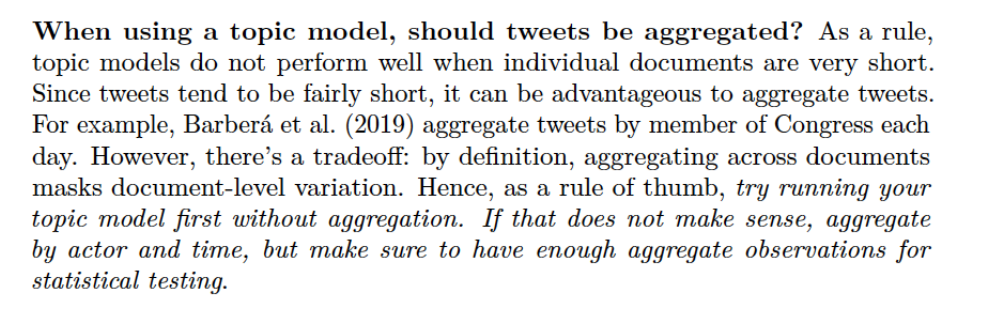

In [104]:
#I need to unpack the list in the dateframe so that they are just strings and not lists of words
tweets['corpus_lem'] = [' '.join(x) for x in tweets['text_lem']]

tweets['corpus_stem'] = [' '.join(x) for x in tweets['text_stem']]


In [105]:
#When running the model the first time,
#we found out that we need to exclude 'sanction' as this is already a sanctions related dataset
#so including the words only obscures the topics

#Removing 'sanction'
#tweets['corpus_lem'] = [x.replace('sanction','') for x in tweets['corpus_lem']]

#Removing 'amp' (amp is a smiley which we deem not relevant for topics but perhaps for another analysis)
tweets['corpus_lem'] = [x.replace('amp','') for x in tweets['corpus_lem']]

#Removing 'russian' as it mainly next to 'russia'
#tweets['corpus_lem'] = [x.replace('russian','') for x in tweets['corpus_lem']]


#Checking if it is removed
#tweets[tweets['corpus_stem'].str.contains('sanctions')]

#Logic for replacing                         
#text = text.replace(word, "")]


In [106]:
#Cutting of the minutes so that I only have the dates

tweets['date_time'] = tweets['date_time'].dt.date
tweets['date_time']

12        2022-02-25
54        2022-02-25
84        2022-02-25
105       2022-05-04
110       2022-05-04
             ...    
605904    2022-02-25
605945    2022-03-10
605946    2022-03-10
605963    2022-03-04
605983    2022-02-25
Name: date_time, Length: 19876, dtype: object

In [107]:
#Aggregating tweet data by dates and MEP
tweets_agg = tweets.groupby(['date_time', 'Name'], as_index = False).agg({'corpus_lem': ' '.join,
                                                                            'corpus_stem': ' '.join})
                                                                            #'clean_text': ' '.join,
                                                                            #'
                                                                            #'text_stem': ' '.join})
            
#Checking dimensions of new dataset and viewing the dataset
print(tweets_agg.shape)
tweets_agg.head()


(8879, 4)


,date_time,Name,corpus_lem,corpus_stem
0,2022-02-20,aldo patriciello,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...
1,2022-02-20,andrea cozzolino,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...
2,2022-02-20,angelo ciocca,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...
3,2022-02-20,arnaud danjean,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...
4,2022-02-20,billy kelleher,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...


In [108]:
#Defining NLTK's TweetTokenizer
tokenizer = TweetTokenizer()

tqdm.pandas() #Creates a progress bar. Use progress_apply instead of apply.

#Creating a column of unigrams from the stemmed tweet text
tweets_agg['unigrams'] = tweets_agg['corpus_lem'].progress_apply(lambda x: tokenizer.tokenize(x))


100%|██████████| 8879/8879 [00:01<00:00, 6507.75it/s]


In [109]:
tweets_agg

,date_time,Name,corpus_lem,corpus_stem,unigrams
0,2022-02-20,aldo patriciello,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ..."
1,2022-02-20,andrea cozzolino,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ..."
2,2022-02-20,angelo ciocca,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ..."
3,2022-02-20,arnaud danjean,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ..."
4,2022-02-20,billy kelleher,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ..."
...,...,...,...,...,...
8874,2022-05-06,tonino picula,here go orban want money rrf drop veto oil emb...,here go orban want money rrf drop veto oil emb...,"[here, go, orban, want, money, rrf, drop, veto..."
8875,2022-05-06,urmas paet,adverse effect delay oil embargo russia advers...,advers effect delay oil embargo russia advers ...,"[adverse, effect, delay, oil, embargo, russia,..."
8876,2022-05-06,valter flego,adverse effect delay oil embargo russia advers...,advers effect delay oil embargo russia advers ...,"[adverse, effect, delay, oil, embargo, russia,..."
8877,2022-05-06,viola von cramon-taubadel,mep believe ukraine need assistance weapon san...,mep believ ukrain need assist weapon sanction ...,"[mep, believe, ukraine, need, assistance, weap..."


In [110]:
#Defining a function that will create bigrams 
def bigrams(doc):
    
    bigrams = [] #Empty list to save the bigrams
    
    for bigram in list(nltk.bigrams(doc)):  #Creating bigrams and iterating over them
        bigrams.append("_".join(bigram))    #Connecting each bigram pair with an underscore and saving to list
    
    return bigrams

#Creating a column with bigrams
tweets_agg['bigrams'] = tweets_agg.unigrams.progress_apply(lambda x: bigrams(x))


100%|██████████| 8879/8879 [00:00<00:00, 65042.90it/s]


In [111]:
#Combining unigrams and bigrams in one column
tweets_agg['tokens'] = tweets_agg.unigrams+tweets_agg.bigrams

In [112]:
#Viewing new dataframe
tweets_agg.head(3)

,date_time,Name,corpus_lem,corpus_stem,unigrams,bigrams,tokens
0,2022-02-20,aldo patriciello,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ...","[zelensky_make, make_potential, potential_sanc...","[zelensky, make, potential, sanction, russia, ..."
1,2022-02-20,andrea cozzolino,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ...","[zelensky_make, make_potential, potential_sanc...","[zelensky, make, potential, sanction, russia, ..."
2,2022-02-20,angelo ciocca,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ...","[zelensky_make, make_potential, potential_sanc...","[zelensky, make, potential, sanction, russia, ..."


In [113]:
#Viewing the tokens in the first row
print(tweets_agg.tokens[400])

['no', 'military', 'support', 'block', 'hardviest', 'possible', 'sanction', 'no', 'chance', 'stop', 'putin', 'shock', 'unfortunately', 'expect', 'attitude', 'deliver', 'germany', 'unfortunately', 'create', 'strong', 'interconnectednessdependencies', 'sanction', 'would', 'hit', 'u', 'well', 'but', 'price', 'pay', 'this', 'insidious', 'attack', 'putin', 'sovereign', 'european', 'country', 'devastate', 'effect', 'action', 'unacceptable', 'reprehensible', 'our', 'answer', 'harsh', 'sanction', 'we', 'show', 'russian', 'president', 'eu', 'stand', 'united', 'people', 'ukraine', 'no_military', 'military_support', 'support_block', 'block_hardviest', 'hardviest_possible', 'possible_sanction', 'sanction_no', 'no_chance', 'chance_stop', 'stop_putin', 'putin_shock', 'shock_unfortunately', 'unfortunately_expect', 'expect_attitude', 'attitude_deliver', 'deliver_germany', 'germany_unfortunately', 'unfortunately_create', 'create_strong', 'strong_interconnectednessdependencies', 'interconnectednessdepen

### 2: Creating a corpus object

We will be using the `gensim` module to create a corpus object and filter very frequent and in-frequent words. Read the documentation here: https://radimrehurek.com/gensim/corpora/dictionary.html 

1. Create a dictionary mapping between words and their ids. This code is provided for you. This can take a couple of seconds.  
2. Use `filter_extremes` to remove very frequent (those that appear in more than 99.9% of the documents) and very infrequent words (those that appear in less than 10 documents).
3. You can inspect the vocabulary using either `id2token` or `token2id`. 
4. Create a corpus object. Essentially, use `doc2bow` in a list comprehension to create a list containing a bag of words for each document (aka for each row in the dataframe). Each bag of words should be a list containing tuples with 1) an index indicating the word and 2) the frequency of that word. The code could look like: `corpus = [id2word.doc2bow(doc) for doc in df['tokens']]`.


In [114]:
#Create a id2word dictionary

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['tokens']) 

#Viewing how many words are in our vocabulary
print(len(id2word))

21071


In [115]:
#Removing very frequent and infrequent words

#Dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
#remove very frequent (those that appear in more than 99.9% of the documents) 
#and very infrequent words (those that appear in less than 10 documents)


id2word.filter_extremes(no_below=10, no_above=.999, keep_n = None)
print(len(id2word))


9026


In [116]:
#Uncomment to see the full vocabulary

for i, token in enumerate(id2word.token2id.keys()):
    print (i,token)

0 cnn
1 invasion
2 invasion_cnn
3 make
4 make_potential
5 possible
6 possible_invasion
7 potential
8 potential_sanction
9 public
10 public_possible
11 russia
12 russia_public
13 sanction
14 sanction_russia
15 zelensky
16 zelensky_make
17 2
18 2_expel
19 asset
20 asset_russian
21 coal
22 coal_scrap
23 diplomat
24 diplomat_freeze
25 expel
26 expel_russian
27 freeze
28 freeze_asset
29 gas
30 gas_oil
31 if
32 nord
33 nord_stream
34 oil
35 oil_coal
36 oligarch
37 oligarch_if
38 russian
39 russian_diplomat
40 russian_gas
41 russian_oligarch
42 sanction_russian
43 scrap
44 scrap_nord
45 stream
46 stream_2
47 traczyk
48 traczyk_sanction
49 agreement
50 ally
51 eu
52 eu_need
53 firm
54 international
55 international_law
56 law
57 minsk
58 minsk_agreement
59 need
60 react
61 react_swift
62 recognition
63 separatist
64 solidarity
65 solidarity_ukraine
66 swift
67 territory
68 the
69 the_eu
70 together
71 two
72 ukraine
73 unity
74 violation
75 act
76 act_recognise
77 breach
78 breach_internationa

1091 saw_challenge
1092 say_germany
1093 say_televise
1094 severe
1095 severe_sanction
1096 solution_do
1097 stop_dependency
1098 stop_eu
1099 summary
1100 summary_bidens
1101 support_putin
1102 support_severe
1103 swift_banking
1104 swift_sa
1105 swift_thi
1106 televise
1107 televise_want
1108 tell
1109 tell_at
1110 the_czech
1111 thi
1112 thi_aslund
1113 today_1
1114 top
1115 top_bank
1116 trade_support
1117 ukraine_international
1118 ukrainewe
1119 ukrainewe_must
1120 union_must
1121 very
1122 very_impressive
1123 want_hard
1124 war_policy
1125 war_ukrainewe
1126 zeman
1127 zeman_say
1128 cease
1129 cut
1130 hit
1131 huge
1132 international_swift
1133 standwithukraine_the
1134 this_would
1135 transfer
1136 withdraw
1137 call_russia
1138 eu_implement
1139 join
1140 join_sign
1141 petition
1142 petition_call
1143 russia_stop
1144 sign_petition
1145 stop_war
1146 war_ukraine
1147 a_pm
1148 attack_freedom
1149 ban_swift
1150 block_decision
1151 but_russia
1152 capital
1153 capital_force

1980 vladimir_putin
1981 24hrs
1982 24hrs_i
1983 but_don
1984 don
1985 don_kick
1986 dont_know
1987 eu_quickly
1988 i_dont
1989 i_kick
1990 important_sign
1991 instrument_stop
1992 know_24hrs
1993 nowit
1994 nowit_important
1995 package_sanction
1996 quickly
1997 quickly_adopt
1998 sanction_strong
1999 sign_eu
2000 stop_military
2001 strong_instrument
2002 swift_nowit
2003 the_tough
2004 ukraine_i
2005 also_united
2006 battle
2007 battle_consequence
2008 but_europe
2009 consequence_war
2010 countersanctions
2011 countersanctions_support
2012 eu_but
2013 europe_show
2014 need_prepared
2015 pay_bill
2016 prepared_countersanctions
2017 regime_eu
2018 sector_pay
2019 show_also
2020 support_new
2021 support_sector
2022 together_we
2023 united_battle
2024 war_together
2025 follow_suit
2026 russia_this
2027 suit
2028 switzerland
2029 apply_emergency
2030 emergency
2031 emergency_measure
2032 ireland_lift
2033 it_apply
2034 lift
2035 lift_visa
2036 measure_ukrainians
2037 requirement
2038 requ

2590 deputy
2591 deputy_polish
2592 germany_nation
2593 hungary_longer
2594 invas
2595 invas_west
2596 longer_oppose
2597 message_pm
2598 nation
2599 nation_world
2600 oppose_swift
2601 pm_poland
2602 poland_germany
2603 polish_foreign
2604 putin_invas
2605 russia_putin
2606 sanctionssource
2607 sanctionssource_deputy
2608 swift_break
2609 swift_sanctionssource
2610 uk_the
2611 west_cut
2612 world_sanction
2613 ally_support
2614 and_think
2615 best_way
2616 equipment_prove
2617 friend_hero
2618 german_government
2619 glad_proud
2620 government_join
2621 happy_read
2622 hero
2623 hero_westandwithukraine
2624 implement_swift
2625 join_ally
2626 military_equipment
2627 proud
2628 proud_and
2629 prove
2630 prove_best
2631 read
2632 read_german
2633 restriction
2634 restriction_glad
2635 swift_restriction
2636 think_ukrainian
2637 ukraine_military
2638 ukrainian_friend
2639 way_implement
2640 also_individual
2641 asset_seize
2642 end_golden
2643 entity
2644 entity_also
2645 include_freeze
2

3340 escalation_stop
3341 eu_close
3342 flight_we
3343 fm_szijjrt
3344 i_fm
3345 inaction
3346 inaction_accelerate
3347 it_costly
3348 mean_stop
3349 natural
3350 natural_gas
3351 nonviolent
3352 nonviolent_mean
3353 oil_russian
3354 place_new
3355 put_place
3356 remember_freedom
3357 risk
3358 risk_escalation
3359 russia_1
3360 russia_set
3361 russian_crude
3362 russian_flight
3363 russian_natural
3364 sanction_nonviolent
3365 set_embargo
3366 stop_i
3367 swiss_inaction
3368 szijjrt
3369 szijjrt_the
3370 u_remember
3371 war_swiss
3372 we_isolate
3373 1_ban
3374 2_nuclear
3375 2_review
3376 announce_it
3377 asset_high
3378 ban_spy
3379 ban_the
3380 bank_base
3381 base_budapest
3382 beach
3383 beach_cayman
3384 broadcast
3385 broadcast_russian
3386 budapest
3387 budapest_2
3388 build_the
3389 cayman
3390 cayman_island
3391 come_deputinisation
3392 come_swift
3393 day_night
3394 defend_weapon
3395 deputinisation
3396 deputinisation_russia
3397 do_embargo
3398 eu_have
3399 exchangeputin
3

4090 eu_unity
4091 fund_similar
4092 gazprombank
4093 independence
4094 sanction_effect
4095 similar
4096 unity_fund
4097 delegation
4098 en_president
4099 en_today
4100 heavy_sanction
4101 large
4102 meps_vote
4103 the_delegation
4104 warwe
4105 issue_sanction
4106 sanction_still
4107 unilateral
4108 en_adopt
4109 negotiation
4110 today_en
4111 trust
4112 metsola
4113 president_announce
4114 seek
4115 agriculture
4116 human
4117 i_ask
4118 eplenary
4119 import_russian
4120 president_ukraine
4121 express
4122 huge_majority
4123 russian_aggressor
4124 project
4125 must_end
4126 decide_ban
4127 eu_council
4128 justice
4129 legal
4130 parliament_vote
4131 process
4132 become
4133 comply
4134 comply_eu
4135 russian_state
4136 state_medium
4137 twitter
4138 twitter_comply
4139 able_sanction
4140 adopt_robust
4141 bank_involve
4142 base_workarounds
4143 check_say
4144 do_gov
4145 dont_check
4146 european_base
4147 far_well
4148 gov
4149 gov_think
4150 inevitably
4151 inevitably_able
4152 inv

5090 ever_break
5091 family_100
5092 herzegovina_the
5093 immediately_enact
5094 import_tariff
5095 it_more
5096 me_why
5097 new_round
5098 propose_new
5099 round
5100 round_sanction
5101 russian_family
5102 sanction_secessionist
5103 secessionist
5104 secessionist_now
5105 set_propose
5106 target_wealthy
5107 tariff
5108 tariff_coalgas
5109 wealthy_russian
5110 why_europe
5111 would_target
5112 broad_support
5113 citizenship_residency
5114 eu_citizenship
5115 parliament_revoke
5116 residency
5117 residency_right
5118 revoke
5119 revoke_eu
5120 right_golden
5121 support_european
5122 visa_russian
5123 1_it
5124 1_u
5125 2_it
5126 a_lot
5127 alternative_replace
5128 ban_we
5129 biden_russian
5130 circle_oligarch
5131 gas_1
5132 gas_alternative
5133 gaswe
5134 gaswe_wont
5135 he_need
5136 help_eu
5137 help_he
5138 import_oil
5139 import_ukraine
5140 it_gaswe
5141 it_russian
5142 let_standwithukraine
5143 lift_help
5144 lot_russian
5145 military_a
5146 need_persuaded
5147 oligarch_secret


6089 here_new
6090 member_next
6091 new_member
6092 orange_here
6093 eu40
6094 build_strong
6095 closely
6096 closely_build
6097 divisionthe
6098 divisionthe_eu
6099 eu_ambassador
6100 exchange_eu
6101 foreign_security
6102 frameworkto
6103 frameworkto_support
6104 policy_frameworkto
6105 refugeestoday
6106 refugeestoday_exchange
6107 russia_to
6108 security_policy
6109 strong_foreign
6110 time_unity
6111 to_sanction
6112 to_welcome
6113 together_closely
6114 uk_work
6115 ukraine_to
6116 unity_divisionthe
6117 welcome_refugeestoday
6118 22_we
6119 add_consensus
6120 consensus
6121 consensus_s
6122 energy_security
6123 hungarys_energy
6124 jeopardize_hungarys
6125 sanction_jeopardize
6126 say_add
6127 security_szijjrt
6128 szijjrt_say
6129 2_on
6130 consolidate
6131 consolidate_unwavering
6132 defence_sanction
6133 embargo_oilgascoal
6134 eu_tribunal
6135 frontline_west
6136 helper
6137 incl
6138 incl_immediate
6139 integration_ua
6140 marshal
6141 marshal_plan
6142 multibillion
6143 mu

6839 overcome_crisis
6840 potential_tougher
6841 role_europe
6842 situation_role
6843 ukrainewe_discuss
6844 view_ukrainewe
6845 advertising_dsa
6846 agree_include
6847 agree_withdraw
6848 ban_dmanow
6849 data_target
6850 demand_put
6851 dmanow
6852 dmanow_time
6853 dsa_parliament
6854 keep_promise
6855 minor_use
6856 parliament_would
6857 pledge_agree
6858 put_ban
6859 target_advertising
6860 time_keep
6861 week_pledge
6862 withdraw_demand
6863 would_agree
6864 aml_risk
6865 ban_cash
6866 ban_unhosted
6867 cash_unneccessary
6868 continue_fight
6869 crypto_seriously
6870 disproportionate
6871 disproportionate_continue
6872 economics
6873 economics_vote
6874 equivalent
6875 equivalent_ban
6876 fight_innovation
6877 innovation
6878 risk_crypto
6879 seriously
6880 seriously_ban
6881 take_aml
6882 tfr
6883 tfr_we
6884 unhosted
6885 unhosted_wallet
6886 unneccessary
6887 unneccessary_disproportionate
6888 vote_tfr
6889 wallet
6890 wallet_this
6891 would_equivalent
6892 ban_meps
6893 blackli

7589 horrendous
7590 horrendous_authoritarian
7591 mep_there
7592 oil_a
7593 sanction_hungary
7594 there_time
7595 time_economic
7596 we_ban
7597 elderly
7598 call_support
7599 embargo_gas
7600 full_immediate
7601 must_hit
7602 russian_import
7603 break_meps
7604 co
7605 co_tsmennys
7606 coal_no
7607 embargo_no
7608 european_mo
7609 favour_greensefa
7610 fuel_embargo
7611 full_fossil
7612 gas_break
7613 greensefa
7614 greensefa_call
7615 muotoilu
7616 muotoilu_immediate
7617 no_european
7618 no_gas
7619 oil_co
7620 parliament_want
7621 specia_break
7622 tarkka
7623 tarkka_muotoilu
7624 tsmennys
7625 tsmennys_tarkka
7626 want_immediate
7627 adopt_resolution
7628 adopts_call
7629 break_en
7630 coal_follow
7631 en_adopts
7632 follow_massacre
7633 in_the
7634 massacre_in
7635 nuclear_break
7636 parliament_adopt
7637 1_billion
7638 35_billion
7639 413
7640 413_meps
7641 513
7642 513_meps
7643 5th_sanction
7644 alexei
7645 alexei_navalny
7646 also_want
7647 ambassador_endorse
7648 ban_russia

8589 abject_predictability
8590 ban_contains
8591 bannedso
8592 bannedso_purpose
8593 clarity
8594 clarity_i
8595 contains
8596 contains_100
8597 deliberately_design
8598 design_see
8599 fact_report
8600 get_ban
8601 get_bannedso
8602 grass
8603 grass_want
8604 i_100
8605 id
8606 id_get
8607 predictability
8608 predictability_tweet
8609 purpose
8610 purpose_clarity
8611 report_twitter
8612 see_id
8613 stand_it
8614 tweet
8615 tweet_deliberately
8616 twitter_grass
8617 want_get
8618 with_abject
8619 also_cut
8620 announce_support
8621 bg
8622 bg_look
8623 cut_gas
8624 declare
8625 declare_stop
8626 embargo_kremlin
8627 embargo_youll
8628 flow_pl
8629 gas_flow
8630 german_sensitive
8631 germany_announce
8632 kind_threat
8633 kremlin_declare
8634 like_msg
8635 msg
8636 msg_youll
8637 pl_bg
8638 sensitive_kind
8639 stay_strong
8640 strong_germany
8641 support_oil
8642 threat_stay
8643 youll
8644 youll_also
8645 youll_support
8646 berlin_pm
8647 during_visit
8648 en_during
8649 germany_en
8

In [118]:
#Creating a corpus object 

corpus = [id2word.doc2bow(doc) for doc in tweets_agg['tokens']]


### 3: Topic modelling

We will run topic modelling using an LDA implementation from the `gensim` module. You can find the documentation here: https://radimrehurek.com/gensim/models/ldamulticore.html 

We will investigate the results of a model with 50 topics. However, this takes several hours to run. Therefore, first try the LDA algorithm with approx. 10 topics and then download the pre-trained model to investigate the 50-topic results.

1. Run the LDA algorithm with the provided code
2. The typical way to get a sense of what each topic actually is means looking at the tokens that are most predictive for each topic. Use `print_topics` to see the 10 (or more) most predictive tokens for each topic. Optional: When using `print_topics`, the model weights are included. If you want to clean this, you can use regex to filter out everything but the words.


**A note on setting parameters:**

- Passes and iterations: As this is just a test run, passes and iterations are set quite low. If you want to use topic modelling in your project, you should make sure to set passes and iterations high enough for the model to converge. In the pre-trained model, passes = 100 and iterations = 1000. 
- Minimum_probability: This filters out all probabilities less than the given number. In the pre-trained model, minimum_probability = 0.000001


**A note on choosing the number of topics:**
Choosing the number of topics is not straightforward. Both Barberá (2019) and Munger (2019) use 10-fold cross-validation for the log-likelihood and perplexity. If you want to implement these models in your own work and want to learn how to do this, read about hyperparameter tuning [here](https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2) or contact Greg who can guide you in R. 

At the same time, there is no statistic that can tell you how many topics you want: "There is often a negative relationship between the best-fitting model and the substantive information provided" (Grimmer and Stewart 2013). So in the end it is a judgment call on the side of the researcher, which can be guided by statistics.

If topics repeat themselves, this may suggest that we chose too many topics for the dataset. 


# We tried 50, 20, 15, 10, and 5 - topics were all the same (BOW)

In [563]:
#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 10 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes = 50, iterations = 100, eval_every = 1)


/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [565]:
from gensim.models.ldamodel import LdaModel


/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [566]:
#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 10 topics 
lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes = 50, iterations = 100, eval_every = 1)


/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [121]:
#Disabling logging again
logging.disable(sys.maxsize)

In [122]:
#Finding the 10 most predictive tokens for each topic

#Using regex to filter the words from the weights 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(10,10)]


In [123]:
# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")
    

------ Topic 0 ------
sanction russia eu swift putin we ban russian must need

------ Topic 1 ------
russia sanction eu putin embargo ban war we stop economic

------ Topic 2 ------
sanction russia eu embargo russian putin oil gas support full

------ Topic 3 ------
sanction russian eu russia war oil the putin ukraine embargo

------ Topic 4 ------
sanction russia russian ban eu war oil european embargo the

------ Topic 5 ------
sanction eu russian russia the putin we eu_sanction need ukraine

------ Topic 6 ------
eu sanction russian gas embargo the russia ukraine oil call

------ Topic 7 ------
sanction embargo russian russia oil eu gas full call ukraine

------ Topic 8 ------
sanction russian russia eu ban putin war the oil gas

------ Topic 9 ------
sanction russia eu russian ukraine oil the embargo putin support



In [18]:
#Code for saving the models

#path = #to the folder in which you want the models saved

#pickle.dump(base_model, open(path+'ldamodel.sav', 'wb'))
#pickle.dump(corpus, open(path+'corpus.sav', 'wb'))
#pickle.dump(id2word, open(path+'id2word.sav', 'wb'))

# Running the model on TF-IDF corpus:

In [318]:
#Creating TF-IDF corpus

from gensim import corpora, models

tfidf = models.TfidfModel(corpus)

corpus_tfidf = tfidf[corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break
    

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.3101202956501547),
 (1, 0.14555283838528998),
 (2, 0.3101202956501547),
 (3, 0.11624368190149525),
 (4, 0.3101202956501547),
 (5, 0.14397629614713556),
 (6, 0.3101202956501547),
 (7, 0.247071198507258),
 (8, 0.3101202956501547),
 (9, 0.19359259285518562),
 (10, 0.3101202956501547),
 (11, 0.03829552260833164),
 (12, 0.3101202956501547),
 (13, 0.013557574485777787),
 (14, 0.07617711809080814),
 (15, 0.2630593930503089),
 (16, 0.3101202956501547)]


In [340]:
# Running the model with TF-IDF corpus

#17

lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=15, 
                                             id2word=id2word, passes = 100, iterations = 300)


#num_topics: 5,10, 15,20,25 (optimal seemed to be 15)
#passes: 1, 5, 50, 100 (optimal seemed to be 100)
#iterations: 50, 100, 200, 300, (optimal seemed to be 300)

#If you want to print right away - I visualize below
#for idx, topic in lda_model_tfidf.print_topics(-1):
 #   print('Topic: {} Word: {}'.format(idx, topic))

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Evaluting the model with coherence, perplexity and loglikelihood

In [328]:
#Evaluating our model with coherence score - it is quite high, which is good

#lda_model_tfidf, id2word, corpus_tfif, tweets_agg['tokens']

# Compute Coherence Score
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=tweets_agg['tokens'], 
                                     dictionary=id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.5529696501076278


In [329]:
#Evaluating our model with perplexity score - it is quite low, which is good

# a measure of how good the model is - lower the better
model_perplexity = lda_model_tfidf.log_perplexity(corpus_tfidf)
print('\nPerplexity: ', model_perplexity) 

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -9.213557747103536


# Ask about loglikelihood in ldamulticore

https://radimrehurek.com/gensim/models/ldamulticore.html

In [262]:
model_loglikelihood = lda_model_tfidf.loglikehood()
print('\nloglikelihood: ', model_loglikelihood) 

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'LdaMulticore' object has no attribute 'loglikehood'

In [ ]:
lda_model_tfidf.

In [ ]:
lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=15, 
                                             id2word=id2word, passes = 100, iterations = 300)

# Test

In [552]:
import tmtoolkit

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [554]:
tmtoolkit.__version__

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'0.11.2'

In [553]:
import matplotlib.pyplot as plt   # for plotting the results
plt.style.use('ggplot')

# for loading the data:
from tmtoolkit.utils import unpickle_file
# for model evaluation with the lda package:
from tmtoolkit.lda_utils import tm_lda
# for constructing the evaluation plot:
from tmtoolkit.lda_utils.common import results_by_parameter
from tmtoolkit.lda_utils.visualize import plot_eval_results

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'tmtoolkit.lda_utils'

In [ ]:
lda_model_tfidf

In [ ]:
lda

In [ ]:
varying_params = [dict(n_topics=k, alpha=1.0/k) for k in ks]

In [558]:
ks = [5, 10, 15, 20]

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#tmtoolkit.topicmod.tm_lda. AVAILABLE_METRICS = ('loglikelihood', 'cao_juan_2009', 'arun_2010', 'coherence_mimno_2011')

In [562]:
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

const_params = {
    'n_iter': 1,
    'random_state': 20191122,  # to make results reproducible
    'eta': 0.1,                # sometimes also called "beta"
}
#ks = [5, 10, 15, 20]
ks = [5]
#metrics = ['loglikelihood', 'coherence_mimno_2011']
metrics = ['loglikelihood']
varying_params = [dict(n_topics=k, alpha=1.0/k) for k in ks]
#varying_params = {'num_topics':[10, 15]}
eval_results = evaluate_topic_models(corpus_tfidf, varying_params, const_params, metrics=metrics)
eval_results[:3]  # only show first three models

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

In [ ]:
lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=15, 
                                             id2word=id2word, passes = 100, iterations = 300)

In [243]:
#Running the model to find optimal number of topics in terms of perplexity score

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
data_vectorized = corpus_tfidf#vectorizer.fit_transform(tweets_agg['tokens'])

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             iid=True, n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))



/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/morten/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py", line 557, in fit
    X = self._check_non_neg_array(X, reset_n_fea

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: Expected 2D array, got 1D array instead:
array=[list([(0, 0.3101202956501547), (1, 0.14555283838528998), (2, 0.3101202956501547), (3, 0.11624368190149525), (4, 0.3101202956501547), (5, 0.14397629614713556), (6, 0.3101202956501547), (7, 0.247071198507258), (8, 0.3101202956501547), (9, 0.19359259285518562), (10, 0.3101202956501547), (11, 0.03829552260833164), (12, 0.3101202956501547), (13, 0.013557574485777787), (14, 0.07617711809080814), (15, 0.2630593930503089), (16, 0.3101202956501547)])
 list([(0, 0.3101202956501547), (1, 0.14555283838528998), (2, 0.3101202956501547), (3, 0.11624368190149525), (4, 0.3101202956501547), (5, 0.14397629614713556), (6, 0.3101202956501547), (7, 0.247071198507258), (8, 0.3101202956501547), (9, 0.19359259285518562), (10, 0.3101202956501547), (11, 0.03829552260833164), (12, 0.3101202956501547), (13, 0.013557574485777787), (14, 0.07617711809080814), (15, 0.2630593930503089), (16, 0.3101202956501547)])
 list([(0, 0.3101202956501547), (1, 0.14555283838528998), (2, 0.3101202956501547), (3, 0.11624368190149525), (4, 0.3101202956501547), (5, 0.14397629614713556), (6, 0.3101202956501547), (7, 0.247071198507258), (8, 0.3101202956501547), (9, 0.19359259285518562), (10, 0.3101202956501547), (11, 0.03829552260833164), (12, 0.3101202956501547), (13, 0.013557574485777787), (14, 0.07617711809080814), (15, 0.2630593930503089), (16, 0.3101202956501547)])
 ...
 list([(11, 0.06091032828164988), (34, 0.10459426853347484), (312, 0.3186538447472625), (1290, 0.09253258862168835), (1425, 0.2560313629855916), (5209, 0.3040139426476644), (5909, 0.2889774789698635), (8999, 0.3828831427571062), (9000, 0.3828831427571062), (9001, 0.3828831427571062), (9002, 0.3828831427571062), (9025, 0.21763477348731886)])
 list([(11, 0.06675865043066423), (13, 0.023634234869713458), (14, 0.1327957226083992), (59, 0.14267975845824818), (72, 0.10389767177895919), (304, 0.4273929316105111), (357, 0.24739687617514533), (587, 0.31758212544910275), (1257, 0.36836815037880855), (1557, 0.46097931370223366), (2309, 0.21720736135064686), (2489, 0.4539750692279324)])
 list([(11, 0.023478987270296847), (13, 0.01662429950484207), (14, 0.04670419579423265), (51, 0.020519938526027796), (85, 0.05427594620013255), (105, 0.05182398656369377), (317, 0.05176574045069321), (333, 0.09708614079504264), (449, 0.08124616104575821), (671, 0.09338038865570136), (690, 0.06750701097268927), (734, 0.1604610348422639), (747, 0.1140633129378291), (753, 0.1604610348422639), (1343, 0.07749642285739182), (1489, 0.06538849882233923), (1666, 0.1604610348422639), (1694, 0.08687960236117277), (1785, 0.10483080187580449), (2583, 0.1390784910677892), (2832, 0.10772758518388306), (2862, 0.11987285001861492), (2863, 0.13012061480326684), (3057, 0.1612817300844584), (3058, 0.1612817300844584), (3826, 0.14193293024852732), (3845, 0.1604610348422639), (3867, 0.15812917029159), (4348, 0.12260934266382915), (5441, 0.12713698359492698), (5894, 0.1386926211288313), (8979, 0.1612817300844584), (9003, 0.16212621687920528), (9004, 0.16212621687920528), (9005, 0.16212621687920528), (9006, 0.16212621687920528), (9007, 0.16212621687920528), (9008, 0.16212621687920528), (9009, 0.16212621687920528), (9010, 0.16212621687920528), (9011, 0.16212621687920528), (9012, 0.16212621687920528), (9013, 0.16212621687920528), (9014, 0.16212621687920528), (9015, 0.16212621687920528), (9016, 0.16212621687920528), (9017, 0.16212621687920528), (9018, 0.16212621687920528), (9019, 0.16212621687920528), (9020, 0.16212621687920528), (9021, 0.16212621687920528), (9022, 0.16212621687920528), (9023, 0.16212621687920528), (9024, 0.16212621687920528)])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [228]:
#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics in terms of coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective number of topics
    """
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=lda_model_tfidf, texts=tweets_agg['tokens'], dictionary=id2word, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic    

# Can take a long time to run.
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus_tfidf,
                                                        texts=tweets_agg['tokens'],
                                                        start=2, limit=200, step=6)



/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [240]:
model_list_topic

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [233]:
(coherence_values_topic)

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661,
 0.6534043902464661]

In [244]:
#import seaborn as sns; sns.set_theme(color_codes=True)


#ax = sns.regplot(x= coherence_values_topic, y=model_list_topic)
                 
                 

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 4.1: Investigating results: beta parameters

To investigate the results, load the pre-trained models with the provided code. 

Retrieve the estimated **beta parameters** from the model. There is a beta per token per topic. A beta indicates how predictive a token is of a document being assigned to a specific topic. 

1. Beta values can be accessed using either `get_topic_terms` (where you input the topic and number of most predictive tokens you want returned) or `get_topics` (which returns the full matrix of beta values). 
2. Pick two or three topics (in the solution code the topics 1, 8, 16, 27, 28, 29, 31, 41, 47, 48 were chosen for visualization). Get the 10 highest beta values and plot these in a horizontal barchart with `sns.barplot`, where x is the beta probability and y is the token. 

Hint: Create a dataframe from the matrix generated by `get_topics` with token names as the column names. Tokens can be retrieved with the `id2word.token2id`. Once you have the dataframe, `nlargest` can be used on a specific row to get the columns with the *n* largest values in that row. 

Intended take-away: The "top terms" for each topic are just the tokens that have the largest beta. 


# We will not import models as we made our own models above

# LDA model on bag of words corpus

In [19]:
#Importing the pre-trained models 

#lda_model=pickle.load(open('ldamodel_50t100p1000i000001minprob.sav', 'rb'))
#corpus=pickle.load(open('corpus_50t100p1000i000001minprob.sav', 'rb'))
#id2word=pickle.load(open('id2word_50t100p1000i000001minprob.sav', 'rb'))


In [148]:
#Uncomment to inspect the vocabulary 

#id2word.id2token

In [149]:
#In the following solution, get_topics() was used to find and visualize beta values 
#get_topic_terms is an alternative that could also have been used.

#Returns (Word ID, probability) pairs for the most relevant words generated by the topic

lda_model.get_topic_terms(9,10) #This returns the 10 words that are most significant for topic 20


[(13, 0.028682701),
 (51, 0.014694089),
 (68, 0.011993136),
 (72, 0.008207608),
 (3066, 0.0077765966),
 (142, 0.007551106),
 (11, 0.0074452907),
 (105, 0.007266171),
 (111, 0.006003392),
 (38, 0.0054023815)]

In [150]:
#Viewing the shape of base_model.get_topics() to verify that the shape is (topics, tokens)

#It is different from above since the first model is only trained on 10 topics while the pret

lda_model.get_topics().shape


(10, 9026)

In [151]:
#Creating a dataframe with tokens as columns and topics as rows 

#token2id gets all tokens and their associated id. list(id2word.token2id.keys()) creates a list of just the tokens. 

beta_df = pd.DataFrame(lda_model.get_topics(), columns = list(id2word.token2id.keys()))


In [152]:
#Viewing the dataframe

beta_df.head()

,cnn,invasion,invasion_cnn,make,make_potential,possible,possible_invasion,potential,potential_sanction,public,...,include_nuclear,must_pull,nuclear_energyrussia,pull_controversial,rely_upon,rosatom_see,see_contribution,stress_importance,upon_hungary,russia_adverse
0,0.000002,0.001223,0.000002,0.000002,0.000002,0.001779,0.000002,0.000002,0.000002,0.000002,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
1,0.000002,0.000002,0.000002,0.002824,0.000002,0.000642,0.000002,0.000002,0.000002,0.000002,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
2,0.000002,0.000115,0.000002,0.001187,0.000002,0.002401,0.000002,0.000002,0.000002,0.000432,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
3,0.000002,0.001116,0.000002,0.002328,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,0.000868,0.000868,0.000868,0.000868,0.000868,0.000868,0.000868,0.000868,0.000868,0.000002
4,0.000001,0.000227,0.000001,0.000257,0.000001,0.000001,0.000001,0.000001,0.000001,0.000543,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000470


In [153]:
#Uncomment to see the 10 words with the largest beta values for each topic 

for i in range(10): 
    print(beta_df.iloc[i].nlargest(10),"\n___\n")

#A note on the results: You may notice that some topics have an even distributions of probabilities for all terms. 
#This may be because the `minimum_probability` parameter is not low enough, 
#    because we do not have enough `passes` and `iterations` and the algorithm has thus not converged properly, 
#    or because we have set the number of topics too high for the data. 
#    For your own projects, experiment with the parameters. 



#Topics:
#Natural resources
#Trade
#Putin
#Russia
#War

#What can we do?
# 1) Exclude more words? No

# 2) Can we do it in rounds? so first detect energy then remove. Now, another round and detect new topics? No




# 3) Try it with new model instead of LDA : https://pypi.org/project/topsbm/ (snorre and hjalmar)

# 4) Find new topics

# 5) run the new FFN using this : https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24


sanction           0.021168
eu                 0.018273
russia             0.012123
russian            0.010450
ban                0.008178
country            0.006999
germany            0.006487
embargo            0.006368
sanction_russia    0.005992
oil                0.005505
Name: 0, dtype: float32 
___

embargo     0.017103
full        0.012766
russian     0.012740
european    0.011710
russia      0.010882
sanction    0.010804
coal        0.009795
oil         0.009759
oil_coal    0.009431
call        0.009115
Name: 1, dtype: float32 
___

sanction    0.017654
russia      0.013379
russian     0.009230
eu          0.008686
the         0.008554
swift       0.007992
putin       0.006723
ukraine     0.006292
ban         0.006229
this        0.005989
Name: 2, dtype: float32 
___

sanction           0.025905
russia             0.018888
eu                 0.011898
russian            0.010119
putin              0.006826
the                0.005744
sanction_russia    0.005566
must          

# LDA model on TF-IDF - the one we chose

tf–idf or TFIDF, short for term frequency-inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf–idf.

In [254]:
lda_model_tfidf.get_topic_terms(10,15)

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(8380, 0.004288624),
 (347, 0.0037210197),
 (72, 0.003503505),
 (8375, 0.0032400591),
 (4604, 0.0030025893),
 (134, 0.0030008513),
 (175, 0.0029540698),
 (66, 0.0029504104),
 (6194, 0.0029324947),
 (170, 0.0028922334),
 (8374, 0.0028843821),
 (8377, 0.0028843821),
 (8373, 0.0028843821),
 (8376, 0.0028843821),
 (8378, 0.0028843821)]

In [385]:
lda_model_tfidf.get_topics().shape

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(15, 9026)

In [386]:
beta_df_tfidf = pd.DataFrame(lda_model_tfidf.get_topics(), columns = list(id2word.token2id.keys()))
beta_df_tfidf.head()

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cnn,invasion,invasion_cnn,make,make_potential,possible,possible_invasion,potential,potential_sanction,public,...,include_nuclear,must_pull,nuclear_energyrussia,pull_controversial,rely_upon,rosatom_see,see_contribution,stress_importance,upon_hungary,russia_adverse
0,0.000013,0.000088,0.000013,0.000141,0.000013,0.000576,0.000013,0.000013,0.000013,0.000013,...,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013
1,0.000020,0.000020,0.000020,0.001053,0.000020,0.002028,0.000020,0.000020,0.000020,0.000020,...,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020
2,0.000017,0.000152,0.000017,0.000684,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017
3,0.000020,0.000020,0.000020,0.001146,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,...,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020
4,0.000013,0.000726,0.000013,0.000958,0.000013,0.000013,0.000013,0.000013,0.000013,0.000919,...,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013


In [387]:
for i in range(15): 
    print(beta_df_tfidf.iloc[i].nlargest(10),"\n___\n")

president           0.003314
the                 0.003077
gas_german          0.002853
stop_gas            0.002785
kremlin             0.002777
russian             0.002750
continue            0.002721
call                0.002623
package_sanction    0.002576
support_putin       0.002521
Name: 0, dtype: float32 
___

what_wait                  0.004739
russia_what                0.004619
wait_westandwithukraine    0.004619
westandwithukraine         0.004379
wait                       0.004287
immediate_sanction         0.003885
eu_continue                0.003859
need                       0.003813
continue_support           0.003773
interview_eu               0.003773
Name: 1, dtype: float32 
___

how                   0.006802
operate               0.005489
operate_russia        0.005489
chinese               0.005473
business_operate      0.005469
chinese_business      0.005469
how_chinese           0.005469
russia_view           0.005469
view_international    0.005469
russiaukrai

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


___

#  RQ: How are sanctions towards Russia expressed by EU parliament members following the invasion of Ukraine on Twitter?


# Visualizing

- Topics: 

- 2: Embargo Russian oil

- 3: Bucha massacre

- 4: Transport

- 5: French export of arms to Russia
https://www.telegraph.co.uk/world-news/2022/04/22/exclusive-france-germany-evaded-arms-embargo-sell-weapons-russia/

- 6: Russian crime state

- 8: Why states will not embargo Russia
https://twitter.com/search?q=former%20polish%20mfa%202042&src=typed_query&f=top 

- 9: Hungary will not allow weapons for Ukraine to transit its territory
https://twitter.com/search?q=hungary%20will%20not%20allow%20lethal%20weapons&src=typed_query&f=top

- 10: Hungary will pay in rubles for Russian oil
https://www.bloomberg.com/news/articles/2022-04-28/hungary-among-buyers-to-allow-ruble-conversion-for-russian-gas

- 11: Economic opportunity after the war

- 12: China does business in Russia
https://twitter.com/search?q=how%20chinese%20businesses%20operate&src=typed_query&f=top

- 13: Sitxh package of sanctions

- 14: 6000 sanctions


In [389]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

gensimvis.prepare(lda_model_tfidf, corpus_tfidf, id2word)

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/morten/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.221793 -0.049243       1        1  9.011440
5      0.239167 -0.101992       2        1  8.357571
0      0.000847  0.094186       3        1  8.266301
7     -0.039616  0.052958       4        1  7.974480
4      0.010326  0.138162       5        1  7.311738
8     -0.028409 -0.011562       6        1  6.923273
2     -0.096035 -0.113604       7        1  6.732770
12     0.036369  0.027906       8        1  6.474732
14    -0.091003 -0.196629       9        1  5.917764
3     -0.054214 -0.020341      10        1  5.883600
13    -0.022715  0.037072      11        1  5.759082
1     -0.070546 -0.037504      12        1  5.706017
11     0.016884  0.169790      13        1  5.702786
6     -0.048465  0.030458      14        1  5.012899
10    -0.074384 -0.019657      15        1  4.965548, topic_info=                Term       Freq      Total Category  logprob  loglift
5909     oil_embargo  55.000000  55.000000  Default  30.0000  30.0000
7554  immediate_full  65.000000  65.000000  Default  29.0000  29.0000
7602  russian_import  54.000000  54.000000  Default  28.0000  28.0000
574   call_immediate  56.000000  56.000000  Default  27.0000  27.0000
35          oil_coal  72.000000  72.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
8544    germany_join  20.538050  27.427531  Topic15  -4.9852   2.7134
8546        join_oil  20.538050  27.427531  Topic15  -4.9852   2.7134
8547    oil_sanction  20.538050  27.427531  Topic15  -4.9852   2.7134
1774     embargo_oil  14.460459  18.522912  Topic15  -5.3360   2.7551
1320            help  14.846551  35.241187  Topic15  -5.3097   2.1382

[737 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5205      3  0.053658            200
5205      5  0.912185            200
7134      3  0.054782       200_meps
7134      5  0.931288       200_meps
8260     11  0.916874           2042
...     ...       ...            ...
8644     13  0.943003     youll_also
7379      4  0.671577           your
7379     13  0.258299           your
7380      4  0.671577  your_strategy
7380     13  0.258299  your_strategy

[1605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 1, 8, 5, 9, 3, 13, 15, 4, 14, 2, 12, 7, 11])

# Visualizing again

In [533]:
100 - sum(data)

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


28.400000000000006

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 432x288 with 0 Axes>

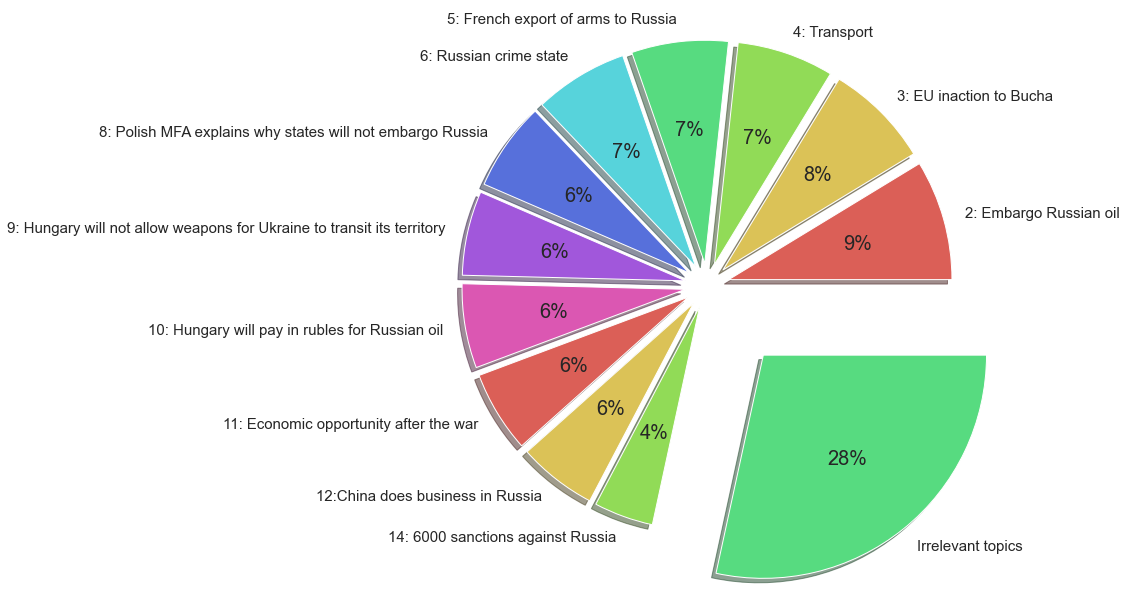

In [541]:
import matplotlib.pyplot as plt
import seaborn as sns


#define data
data = [8.7, 7.6, 7, 7, 6.8, 6.4, 6.1, 6.1, 5.9, 5.7, 4.3, 28.400000000000006]
labels = ['2: Embargo Russian oil', '3: EU inaction to Bucha', '4: Transport', '5: French export of arms to Russia', '6: Russian crime state', 
          '8: Polish MFA explains why states will not embargo Russia', 
          '9: Hungary will not allow weapons for Ukraine to transit its territory',
         '10: Hungary will pay in rubles for Russian oil', 
         '11: Economic opportunity after the war',
         '12:China does business in Russia', 
         '14: 6000 sanctions against Russia',
         'Irrelevant topics']

explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4)


#define Seaborn color palette to use
colors = sns.color_palette("hls", 8)

#create pie chart
plt.rcParams.update({'font.size': 20})

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

plt.figure(0)
plt.figure(figsize=(10, 20))
plt.pie(data, labels = labels, explode = explode, colors = colors, autopct='%.f%%',shadow=True )


plt.show();

In [ ]:
# Plot with autopct

colors=['rosybrown', 'moccasin', 'lightyellow', 'darkseagreen','salmon','palegreen','skyblue','silver'] #,'plum'
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

plt.figure(0)
plt.figure(figsize=(8,10))
plt.title('Distribution of "likes" by EU Party', fontweight='bold')
plt.pie(party_df.fav_by_party, explode=explode,shadow=True,labels=party_df.index, autopct='%.1f%%', wedgeprops={'edgecolor':'maroon','alpha':0.5}, colors=colors)
#plt.savefig('Save Pie Chart.png')

# Create second chart.

plt.figure(1)
plt.figure(figsize=(8,10))
plt.title('Distribution of EU Party retweets', fontweight='bold')
plt.pie(party_df.retw_by_party, explode=explode, shadow=True, labels=party_df.index, autopct='%.1f%%', wedgeprops={'edgecolor':'maroon','alpha':0.5}, colors=colors) 
#plt.savefig('Save Pie Chart.png')

# Create third chart.

plt.figure(2)
plt.figure(figsize=(8,10))
plt.title('Distribution of times EU Party is retweeted', fontweight='bold')
plt.pie(party_df.retwed_by_party, explode=explode, shadow=True, labels=party_df.index, autopct='%.1f%%', wedgeprops={'edgecolor':'maroon','alpha':0.5}, colors=colors) 
#plt.savefig('Save Pie Chart.png')

plt.show()

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


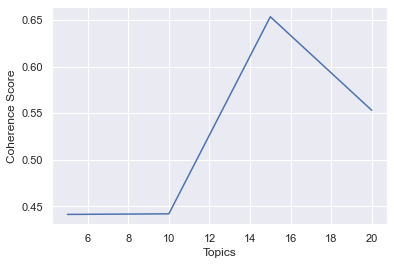

In [337]:
import seaborn as sns; sns.set_theme(color_codes=True)


Topics = [5,10,15,20]
Coherence_Score = [0.44125938370098894, 0.44189384609031424, 0.6534043902464661, 0.5529696501076278]

df_ = pd.DataFrame()

df_['Topics'] = Topics
df_['Coherence Score'] = Coherence_Score

ax = sns.lineplot(data = df_, x='Topics', y='Coherence Score', markers = True, dashes = False)



/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


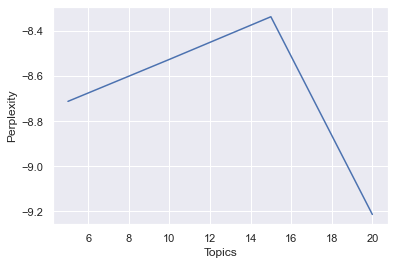

In [338]:
import seaborn as sns; sns.set_theme(color_codes=True)

perplexity = [ -8.71195182727621,  -8.52564871725331,  -8.33648335191466, -9.21355774710353]

df_['Topics'] = Topics
df_['Perplexity'] = perplexity

ax = sns.lineplot(data = df_, x='Topics', y='Perplexity', markers = True, dashes = False)


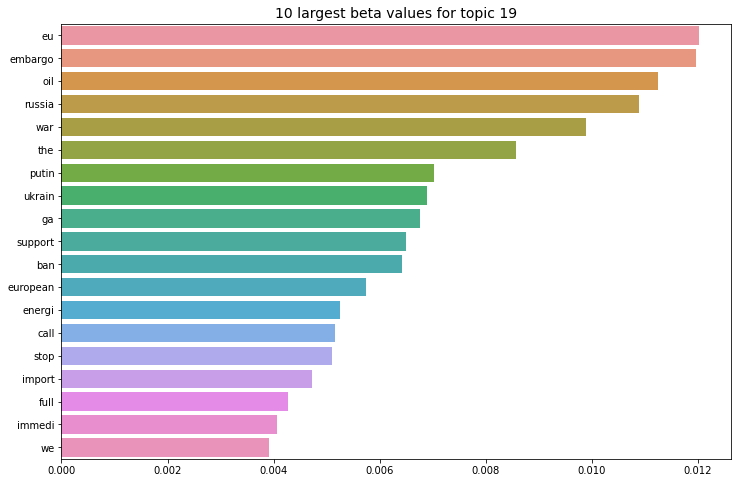

In [169]:
#Visualizing topic 41

#beta_df.iloc[41].nlargest(10) locates the 10 largest values in row 41. 
# .values returns the beta values
# .index returns the words

plt.figure(figsize = (12,8))

ax = sns.barplot(x = beta_df.iloc[10].nlargest(19).values, 
                 y = beta_df.iloc[10].nlargest(19).index, 
                 orient = 'h')

plt.title('10 largest beta values for topic 19', fontsize = 14)
plt.show()

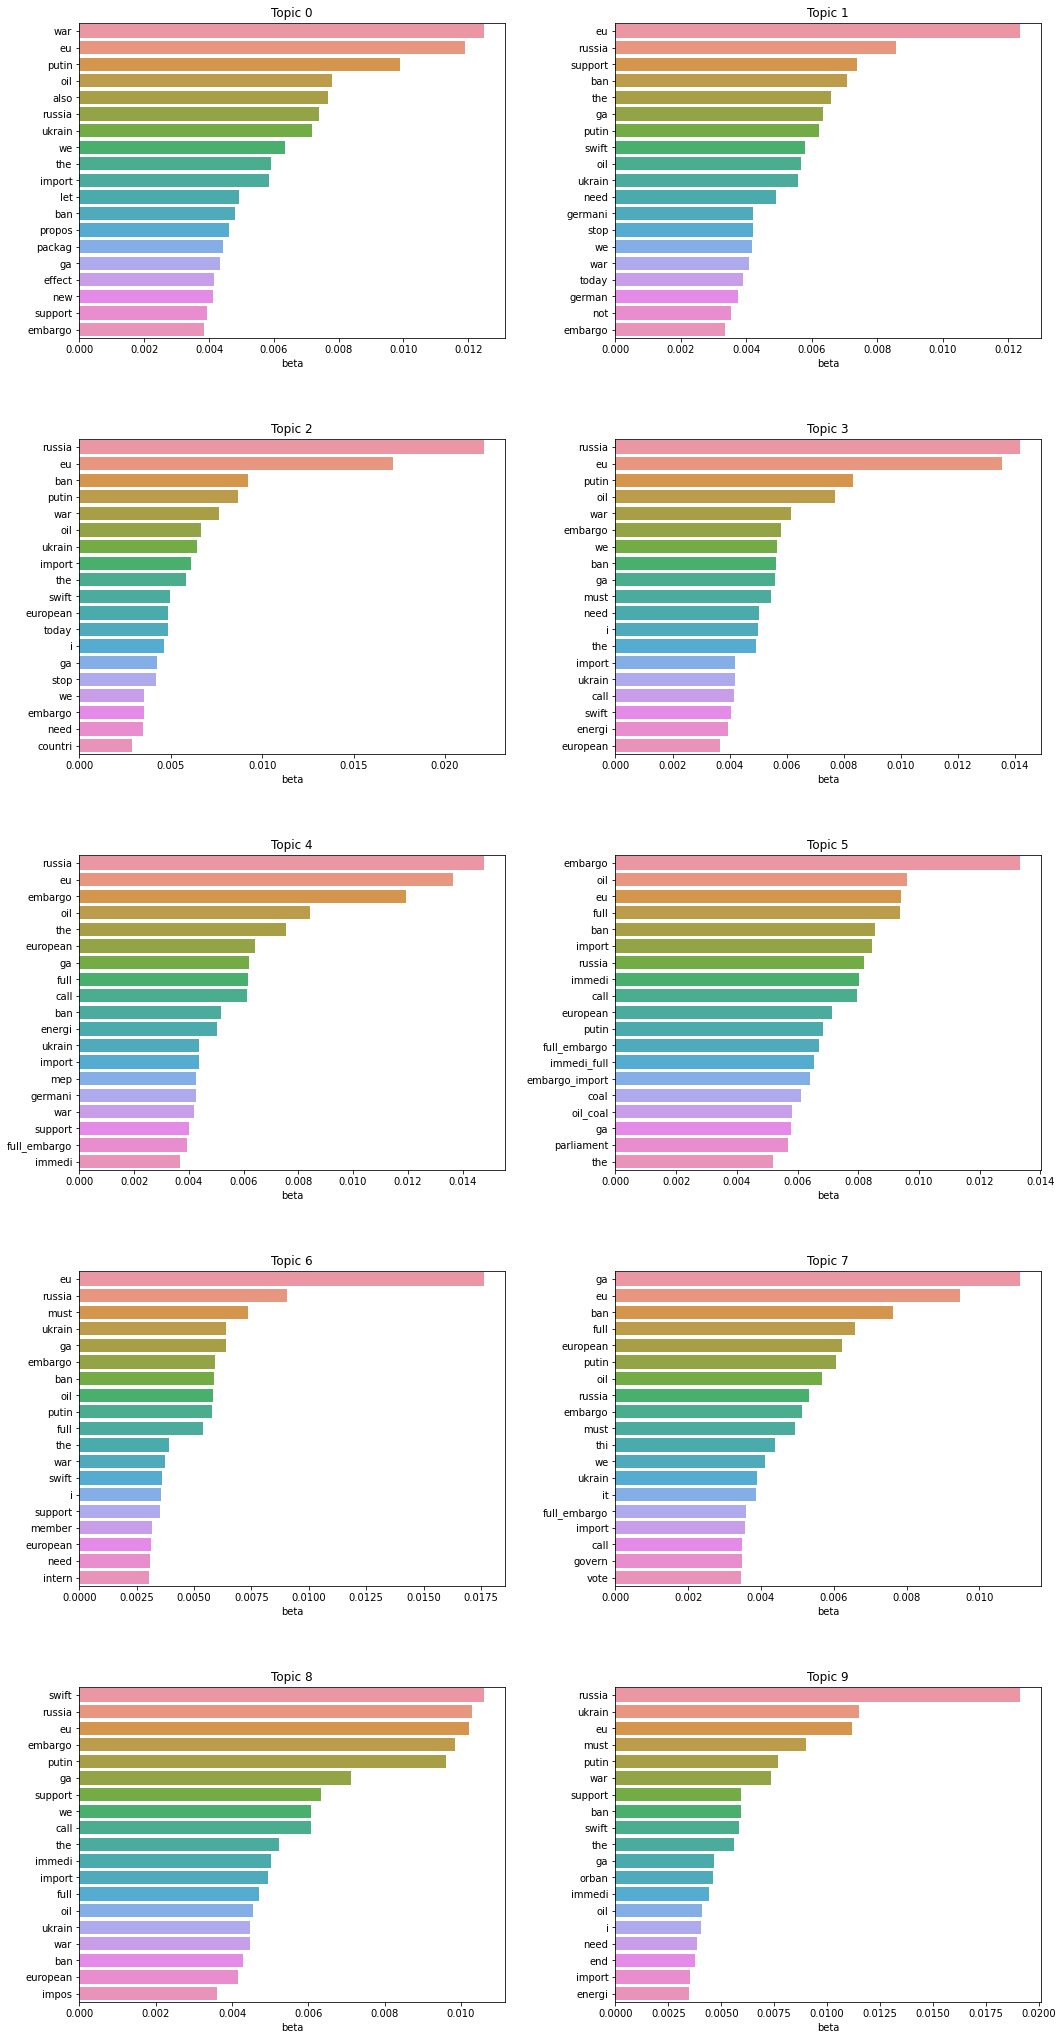

In [170]:
#Visualizing first 10 topics
topics = [i for i in range(10)]

fig, axes = plt.subplots(ncols=2, nrows=5, figsize = (16,30)) #Setting 10 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 10 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(19).values, 
                y = beta_df.iloc[topic].nlargest(19).index, 
                orient = 'h')
    
    ax.set(title='Topic {}'.format(topic), xlabel='beta')

plt.show()


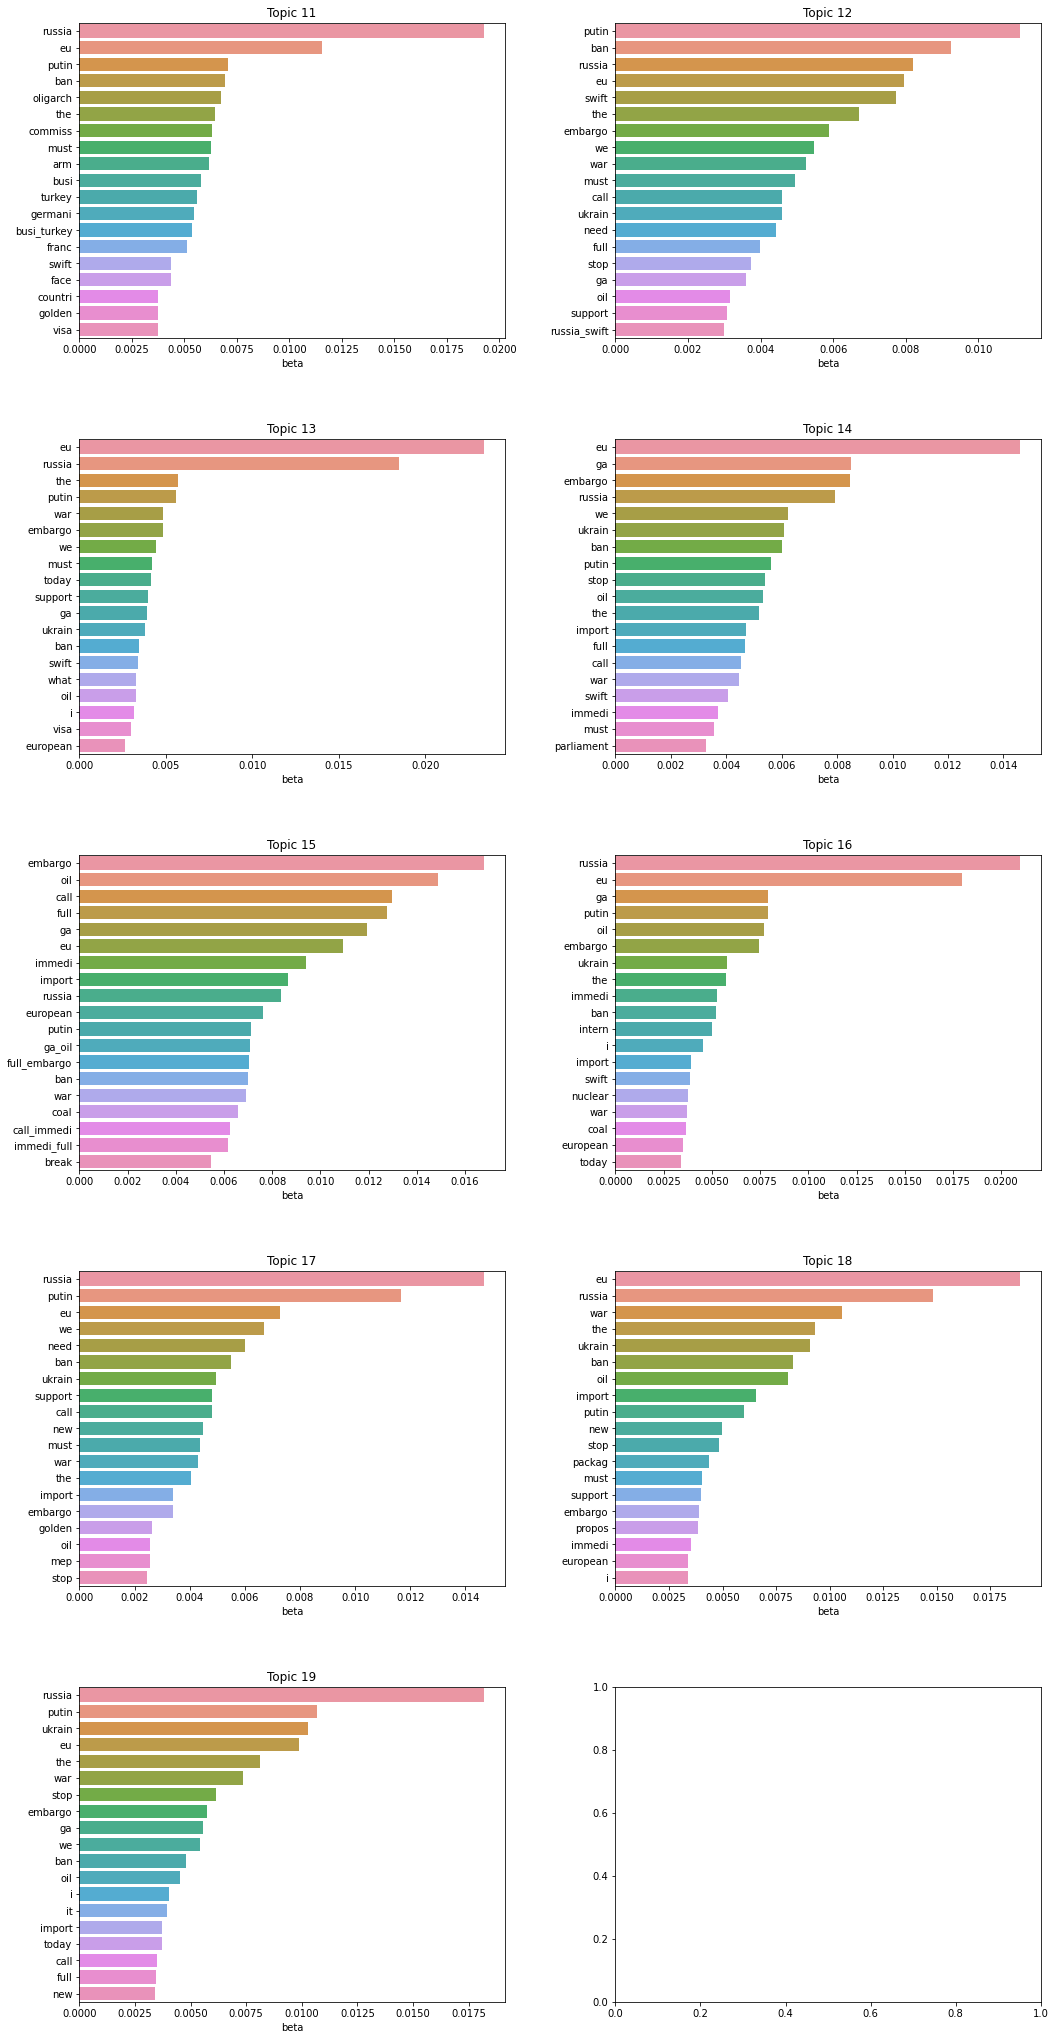

In [171]:
#Visualizing last topics
topics = [11,12,13,14,15,16,17,18,19]

fig, axes = plt.subplots(ncols=2, nrows=5, figsize = (16,30)) #Setting 10 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 10 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(19).values, 
                y = beta_df.iloc[topic].nlargest(19).index, 
                orient = 'h')
    
    ax.set(title='Topic {}'.format(topic), xlabel='beta')

plt.show()

### 4.2: Investigating results: gamma parameters

Retrieve the estimated **gamma parameters** from the model. For each document, you will get a list of topics with an associated gamma. The gammas indicate the probability (or amount) that a document is about a specific topic.

1. Use `get_document_topics` with the full corpus to get lists of probabilities for each document.
2. Save the probabilities in the original dataframe. You can find inspiration for how to do this in this pseudo-code:

**Pseudo-code to save the probabilities in the original dataframe:**

Use list comprehension to create a list of 50 topic names (e.g. topic_1, topic_2 etc.)

Create a dataframe filled with zeros of the shape (number of documents - 864, number of topics - 50) and with columns = the list of 50 topic names. 

For each index, document in the list of gamma probabilities: <br>
<font color=white>0000</font>for each topic-probability pair in the document: <br>
<font color=white>00000000</font>locate index and column with that topic name and save the probability

Concatenate this dataframe with the original dataframe over axis 1.



In [341]:
#Insert the corpus of documents in bag of word format and get an array of (document, topic, probability). 

import numpy as np

document_topics = np.array(lda_model_tfidf.get_document_topics(corpus_tfidf, minimum_probability=0.0)) 


/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [342]:
document_topics

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[ 0.        ,  0.01413165],
        [ 1.        ,  0.01413166],
        [ 2.        ,  0.01413165],
        ...,
        [12.        ,  0.01413165],
        [13.        ,  0.01413166],
        [14.        ,  0.80215687]],

       [[ 0.        ,  0.01413165],
        [ 1.        ,  0.01413166],
        [ 2.        ,  0.01413165],
        ...,
        [12.        ,  0.01413165],
        [13.        ,  0.01413166],
        [14.        ,  0.80215687]],

       [[ 0.        ,  0.01413164],
        [ 1.        ,  0.01413166],
        [ 2.        ,  0.01413164],
        ...,
        [12.        ,  0.01413164],
        [13.        ,  0.01413165],
        [14.        ,  0.80215693]],

       ...,

       [[ 0.        ,  0.01596882],
        [ 1.        ,  0.01596882],
        [ 2.        ,  0.01596882],
        ...,
        [12.        ,  0.01596882],
        [13.        ,  0.01596882],
        [14.        ,  0.01596882]],

       [[ 0.        ,  0.01683433],
        [ 1.        ,  0.01

In [30]:
#Uncomment to view gamma values for the first document

#print(document_topics.shape)
#document_topics[0]


In [343]:
#Creating a list of names for all 50 topics
topics = ['topic_{}'.format(t) for t in range(0,15)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(document_topics[:,:,1], columns = topics)

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [344]:
#Merging with the original dataframe 
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

#Viewing the concatenated dataframe
gamma_df.head()

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_time,Name,corpus_lem,corpus_stem,unigrams,bigrams,tokens,topic_0,topic_1,topic_2,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,2022-02-20,aldo patriciello,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ...","[zelensky_make, make_potential, potential_sanc...","[zelensky, make, potential, sanction, russia, ...",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157
1,2022-02-20,andrea cozzolino,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ...","[zelensky_make, make_potential, potential_sanc...","[zelensky, make, potential, sanction, russia, ...",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157
2,2022-02-20,angelo ciocca,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ...","[zelensky_make, make_potential, potential_sanc...","[zelensky, make, potential, sanction, russia, ...",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157
3,2022-02-20,arnaud danjean,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ...","[zelensky_make, make_potential, potential_sanc...","[zelensky, make, potential, sanction, russia, ...",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157
4,2022-02-20,billy kelleher,zelensky make potential sanction russia public...,zelenski make potenti sanction russia public p...,"[zelensky, make, potential, sanction, russia, ...","[zelensky_make, make_potential, potential_sanc...","[zelensky, make, potential, sanction, russia, ...",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157


In [635]:
#np.random.seed(1)
illustrative = gamma_df.sample(5)


/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [636]:
#illustrative['create'] = illustrative.idxmax(axis = 1)

illu = illustrative[['corpus_lem','topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_13']]


/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [638]:

illu2 = illu.copy()
illu2['Label_topic'] = illu.drop("corpus_lem",axis=1).apply(lambda x:x[(x==x.max())].index.to_series().sample(frac=1).iloc[0],axis = 1)
illu2

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,corpus_lem,topic_1,topic_2,topic_3,topic_4,topic_5,topic_7,topic_8,topic_9,topic_10,topic_11,topic_13,Label_topic
5524,bucha evidence kremlin nazism nazism need defeat totally proper gun max sanction gun ua sanction ru responsibility west tribunal putin full capitulation take good look evidence genocide bucha town this russkyi mir putin dream bring also baltic state poland berlin call urgent impose russian oilgas embargo provide weapon ua need defend u hku germany ban street demonstration russians support putin display symbol z sh horrible massacre bucha the perpetrator alongside putin must investigate war crime genocide western world must help ukraine kick russian invader apply sanction putin regime,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,topic_3
6812,my interview pb eu sanction russia continued support ukraine ahe 3 we need continue increase pressure russia we impose massive sanction already need b,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.868565,topic_13
4747,member en address letter ask eu add sanction list several russian individual play importantrole russian government propaganda effort home abroad standwithukraine our letter european parliament sign 103 ep member imperative strengheningof sanction russia include full trade embargo oil gas coal,0.007300,0.007300,0.007300,0.897799,0.007300,0.007300,0.007300,0.007300,0.007300,0.007300,0.007300,topic_4
306,petras meps call immediate additional sanction putin regime support ukraine defend sovereignty to,0.012060,0.012060,0.831156,0.012060,0.012060,0.012060,0.012060,0.012060,0.012060,0.012060,0.012060,topic_3
2883,sanction until last occupier leavesputin lose war what term capitulationsoldiers leave kherson mariupol chernobyl also donetsk luhansk crimea only todays economic sanction lift broad support european parliament revoke eu citizenship residency right golden passport visa of,0.007357,0.007357,0.007357,0.007357,0.007357,0.007357,0.897003,0.007357,0.007357,0.007357,0.007357,topic_8


In [640]:
illu3 = illu.copy()

illu3['Label_topic_1'] = illu.drop("corpus_lem",axis=1).apply(lambda x:x[(x==x.max())].index.to_series().sample(frac=1).iloc[0],axis = 1)
illu3

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,corpus_lem,topic_1,topic_2,topic_3,topic_4,topic_5,topic_7,topic_8,topic_9,topic_10,topic_11,topic_13,Label_topic_1
5524,bucha evidence kremlin nazism nazism need defeat totally proper gun max sanction gun ua sanction ru responsibility west tribunal putin full capitulation take good look evidence genocide bucha town this russkyi mir putin dream bring also baltic state poland berlin call urgent impose russian oilgas embargo provide weapon ua need defend u hku germany ban street demonstration russians support putin display symbol z sh horrible massacre bucha the perpetrator alongside putin must investigate war crime genocide western world must help ukraine kick russian invader apply sanction putin regime,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,0.005170,topic_3
6812,my interview pb eu sanction russia continued support ukraine ahe 3 we need continue increase pressure russia we impose massive sanction already need b,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.009388,0.868565,topic_13
4747,member en address letter ask eu add sanction list several russian individual play importantrole russian government propaganda effort home abroad standwithukraine our letter european parliament sign 103 ep member imperative strengheningof sanction russia include full trade embargo oil gas coal,0.007300,0.007300,0.007300,0.897799,0.007300,0.007300,0.007300,0.007300,0.007300,0.007300,0.007300,topic_4
306,petras meps call immediate additional sanction putin regime support ukraine defend sovereignty to,0.012060,0.012060,0.831156,0.012060,0.012060,0.012060,0.012060,0.012060,0.012060,0.012060,0.012060,topic_3
2883,sanction until last occupier leavesputin lose war what term capitulationsoldiers leave kherson mariupol chernobyl also donetsk luhansk crimea only todays economic sanction lift broad support european parliament revoke eu citizenship residency right golden passport visa of,0.007357,0.007357,0.007357,0.007357,0.007357,0.007357,0.897003,0.007357,0.007357,0.007357,0.007357,topic_8


In [644]:
abc = illu3.drop("corpus_lem",axis=1).T
abc

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_1          False
topic_2          False
topic_3          False
topic_4          False
topic_5           True
topic_7          False
topic_8           True
topic_9          False
topic_10          True
topic_11          True
topic_13         False
Label_topic_1    False
Name: 5524, dtype: bool

In [630]:
gamma_df.shape

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(8879, 22)

In [491]:
gamma_a = gamma_df

pd.set_option('display.max_colwidth', None)
s = gamma_a.sort_values(by = 'topic_1', ascending = False)
s['topic_4']

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3081    0.005175
3194    0.005175
3074    0.005175
3073    0.005175
3138    0.005175
          ...   
512     0.022841
427     0.023103
478     0.034252
597     0.034279
384     0.034301
Name: topic_4, Length: 8879, dtype: float64

In [ ]:


Keywords: ['sanction', 'sanctions', 'sanctioning', 'visa', 'freeze', 'embargo', 'ban', 'nordstream', 'blacklist', 'swift']

Exclusion List: ['lithuania', 'afghanistan', 'iran', 'iranian', 'uyghur', 'bitcoin', 'fracking', 
                'rule', 'ryanair', 'therapy', 'shale', 'SaudiArabia', 'UEFA', 'FIFA', 'abortion', 
                 'trudeau', 'jesuis', 'indy', 'turf', 'asylum', 'digital', 'anonymous', 'gdpr']


In [496]:
s[s['corpus_lem'].str.contains('break')]
#https://www.bloomberg.com/news/articles/2022-04-28/hungary-among-buyers-to-allow-ruble-conversion-for-russian-gas


/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_time,Name,corpus_lem,corpus_stem,unigrams,bigrams,tokens,topic_0,topic_1,topic_2,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
1233,2022-02-26,pierre karleskind,europa kick russia swift expulsemos rusia del sistema swiftwe need stop russias aggression uk the fact euco act fast sanction russia good thing but exclude russia swift be clear message pm poland germany nation world sanction russia putin invas west cut russian bank swift break hungary longer oppose swift sanctionssource deputy polish foreign minister,europa kick russia swift expulsemo rusia del sistema swiftw need stop russia aggress uk the fact euco act fast sanction russia good thing but exclud russia swift is clear messag pm poland germani nation world sanction russia putin inva west cut russian bank swift break hungari longer oppos swift sanctionssourc deputi polish foreign minist,"[europa, kick, russia, swift, expulsemos, rusia, del, sistema, swiftwe, need, stop, russias, aggression, uk, the, fact, euco, act, fast, sanction, russia, good, thing, but, exclude, russia, swift, be, clear, message, pm, poland, germany, nation, world, sanction, russia, putin, invas, west, cut, russian, bank, swift, break, hungary, longer, oppose, swift, sanctionssource, deputy, polish, foreign, minister]","[europa_kick, kick_russia, russia_swift, swift_expulsemos, expulsemos_rusia, rusia_del, del_sistema, sistema_swiftwe, swiftwe_need, need_stop, stop_russias, russias_aggression, aggression_uk, uk_the, the_fact, fact_euco, euco_act, act_fast, fast_sanction, sanction_russia, russia_good, good_thing, thing_but, but_exclude, exclude_russia, russia_swift, swift_be, be_clear, clear_message, message_pm, pm_poland, poland_germany, germany_nation, nation_world, world_sanction, sanction_russia, russia_putin, putin_invas, invas_west, west_cut, cut_russian, russian_bank, bank_swift, swift_break, break_hungary, hungary_longer, longer_oppose, oppose_swift, swift_sanctionssource, sanctionssource_deputy, deputy_polish, polish_foreign, foreign_minister]","[europa, kick, russia, swift, expulsemos, rusia, del, sistema, swiftwe, need, stop, russias, aggression, uk, the, fact, euco, act, fast, sanction, russia, good, thing, but, exclude, russia, swift, be, clear, message, pm, poland, germany, nation, world, sanction, russia, putin, invas, west, cut, russian, bank, swift, break, hungary, longer, oppose, swift, sanctionssource, deputy, polish, foreign, minister, europa_kick, kick_russia, russia_swift, swift_expulsemos, expulsemos_rusia, rusia_del, del_sistema, sistema_swiftwe, swiftwe_need, need_stop, stop_russias, russias_aggression, aggression_uk, uk_the, the_fact, fact_euco, euco_act, act_fast, fast_sanction, sanction_russia, russia_good, good_thing, thing_but, but_exclude, exclude_russia, russia_swift, swift_be, be_clear, clear_message, message_pm, pm_poland, poland_germany, germany_nation, nation_world, world_sanction, sanction_russia, russia_putin, putin_invas, invas_west, west_cut, cut_russian, russian_bank, bank_swift, swift_break, break_hungary, hungary_longer, ...]",0.006409,0.910275,0.006409,...,0.006409,0.006409,0.006409,0.006409,0.006409,0.006409,0.006409,0.006409,0.006409,0.006409
1267,2022-02-26,tom vandendriessche,europa kick russia swift expulsemos rusia del sistema swiftwe need stop russias aggression uk the fact euco act fast sanction russia good thing but exclude russia swift be clear message pm poland germany nation world sanction russia putin invas west cut russian bank swift break hungary longer oppose swift sanctionssource deputy polish foreign minister,europa kick russia swift expulsemo rusia del sistema swiftw need stop russia aggress uk the fact euco act fast sanction russia good thing but exclud russia swift is clear messag pm poland germani nation world sanction russia putin inva west cut russian bank swift break hungari longer oppos swift sanctionssourc deputi polish foreign minist,"[europa, kick, russia, swift, expulsemos, rusia

In [355]:
top = gamma_df.groupby('tokens')



/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 5: Visualizing the development of the coronavirus related topic 

Getting back to the original question: How has the topic of coronavirus progressed on Twitter among Members of Congress over time? 

1. Use `print_topics` to look through the 10 most relevant words of each topic and identify the topic related to coronavirus. 
2. If it is not already, convert the date column from string type to datetime type
3. Graph the development of the coronavirus topic over time. Create a plot where x = date, y = the covid topic, and hue = affiliation. 
4. Do the same with a subset of the dataset only including 2020. 

Can you see which party was quicker to set the agenda around COVID-19? 


In [267]:
#Using regex to find all words and filter them from the weights
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model_tfidf.print_topics(15,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")
    
#Topic 41 is coronavirus


------ Topic 0 ------
possible_eu advocate target_russian the_6th russian_o package_target ireland_continue continue_advocate advocate_strong 6th_eu

------ Topic 1 ------
phase also opportunity propose_new win_war also_eu reconstruction_fund war_challenge phase_oil opportunity_invest

------ Topic 2 ------
6000 already_impose tv_6000 world_record 6000_sanction russia_world chancellor_scholz impose_russia chancellor record

------ Topic 3 ------
alter afraid brave vladimir_continue freedomloving freedomloving_russian detain_must crime_vladimir the_kremlin continue_detain

------ Topic 4 ------
immediate_sanction chinese operate_russia operate view_international russia_view business_operate how_chinese chinese_business sanction_embargo

------ Topic 5 ------
russian_oil new oil_import announce import here ban today oil proposal

------ Topic 6 ------
mfa cooperation_russia mfa_eu polish_mfa politician_embargo energythey_value energythey former_polish 2042 value_cooperation

------ Topic

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [296]:
#Viewing the topics
#gamma_df

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [272]:
#Converting date from str type to datetime type
#gamma_df['date'] = pd.to_datetime(gamma_df['date'])

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [544]:
gamma_df

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_time,Name,corpus_lem,corpus_stem,unigrams,bigrams,tokens,topic_0,topic_1,topic_2,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,2022-02-20,aldo patriciello,zelensky make potential sanction russia public possible invasion cnn,zelenski make potenti sanction russia public possibl invas cnn,"[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn]","[zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]","[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn, zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157
1,2022-02-20,andrea cozzolino,zelensky make potential sanction russia public possible invasion cnn,zelenski make potenti sanction russia public possibl invas cnn,"[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn]","[zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]","[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn, zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157
2,2022-02-20,angelo ciocca,zelensky make potential sanction russia public possible invasion cnn,zelenski make potenti sanction russia public possibl invas cnn,"[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn]","[zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]","[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn, zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157
3,2022-02-20,arnaud danjean,zelensky make potential sanction russia public possible invasion cnn,zelenski make potenti sanction russia public possibl invas cnn,"[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn]","[zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]","[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn, zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157
4,2022-02-20,billy kelleher,zelensky make potential sanction russia public possible invasion cnn,zelenski make potenti sanction russia public possibl invas cnn,"[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn]","[zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]","[zelensky, make, potential, sanction, russia, public, possible, invasion, cnn, zelensky_make, make_potential, potential_sanction, sanction_russia, russia_public, public_possible, possible_invasion, invasion_cnn]",0.014132,0.014132,0.014132,...,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.014132,0.802157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8874,2022-05-06,tonino picula,here go orban want money rrf drop veto oil embargo,here go orban want money rrf drop veto oil embargo,"[here, go, orban, want, money, rrf, drop

In [546]:
#Sorting to get the top values:
s = gamma_a.sort_values(by = 'topic_0', ascending = False)


/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [547]:
#Uncomment to see all probabilities for the covid topic 

for prob in s['topic_0']:
    print(prob)

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.9306864142417908
0.930686354637146
0.926034152507782
0.926034152507782
0.926034152507782
0.926034152507782
0.9260340929031372
0.9260340929031372
0.9260340929031372
0.9260340929031372
0.9260340929031372
0.9260340929031372
0.9260340929031372
0.9260340929031372
0.9260340929031372
0.9260340929031372
0.9260340929031372
0.926034092903137

0.012965124100446701
0.012965123169124126
0.012965123169124126
0.012965123169124126
0.012965122237801552
0.012965122237801552
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965121306478977
0.012965119443833828
0.012965119443833828
0.012965119443833828
0.012965119443833828
0.012965119443833828
0.012965119443833828
0.012965118512511253
0.012965118512511253
0.012965118512511253
0.012965118512511253
0.012944800779223442
0.012940625660121441
0.012888818047940731
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.01288333535194397
0.0128833

0.010401894338428974
0.010401894338428974
0.010401894338428974
0.010401894338428974
0.010401894338428974
0.010401894338428974
0.010401894338428974
0.010401894338428974
0.0104018934071064
0.0104018934071064
0.0104018934071064
0.010401892475783825
0.010382928885519505
0.010382928885519505
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.01038292795419693
0.010382927022874355
0.01038292609155178
0.010367335751652718
0.010367335751652718
0.010367335751652718
0.010367334820330143
0.010367334820330143
0.010367334820330143
0.010367334820330143
0.010367334820330143
0.010367333889007568
0.010367333889007568
0.010367333889007568
0.010367333889007568
0.010367333889007568
0.0103673338890075

0.008670118637382984
0.008670118637382984
0.008670118637382984
0.00867011770606041
0.00867011770606041
0.00867011770606041
0.008670116774737835
0.008670116774737835
0.008670116774737835
0.00867011584341526
0.00867011584341526
0.00866971630603075
0.008638648316264153
0.008638647384941578
0.008612606674432755
0.008595571853220463
0.008595571853220463
0.008595571853220463
0.008595571853220463
0.008595571853220463
0.008595571853220463
0.008595571853220463
0.008595571853220463
0.008595570921897888
0.008595570921897888
0.008595570921897888
0.008595566265285015
0.008591054007411003
0.008591053076088428
0.008565363474190235
0.008565363474190235
0.008565363474190235
0.00856536254286766
0.008565361611545086
0.008565361611545086
0.008565360680222511
0.008565359748899937
0.008565358817577362
0.008565358817577362
0.008565358817577362
0.008565358817577362
0.008565358817577362
0.008565357886254787
0.008565357886254787
0.008565357886254787
0.008565356954932213
0.008564028888940811
0.008564028888940811

0.006735228467732668
0.006735228467732668
0.006735228467732668
0.006735228002071381
0.006735228002071381
0.006735228002071381
0.006735228002071381
0.006735228002071381
0.006735228002071381
0.006735227536410093
0.006735227536410093
0.006735226605087519
0.006735226605087519
0.006735226605087519
0.006735226605087519
0.006735226139426231
0.006735226139426231
0.006735225208103657
0.006735225208103657
0.006735225208103657
0.006735225208103657
0.0067352247424423695
0.0067352247424423695
0.0067352247424423695
0.0067352247424423695
0.0067352247424423695
0.0067352247424423695
0.006735224276781082
0.006735224276781082
0.0067352233454585075
0.0067352233454585075
0.0067352233454585075
0.0067352233454585075
0.0067352233454585075
0.0067352233454585075
0.0067352233454585075
0.00673522287979722
0.00673522287979722
0.00673522287979722
0.00673522287979722
0.006735221948474646
0.006735221482813358
0.006735221482813358
0.006735221482813358
0.006735221017152071
0.006718227174133062
0.006718226242810488
0.00

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


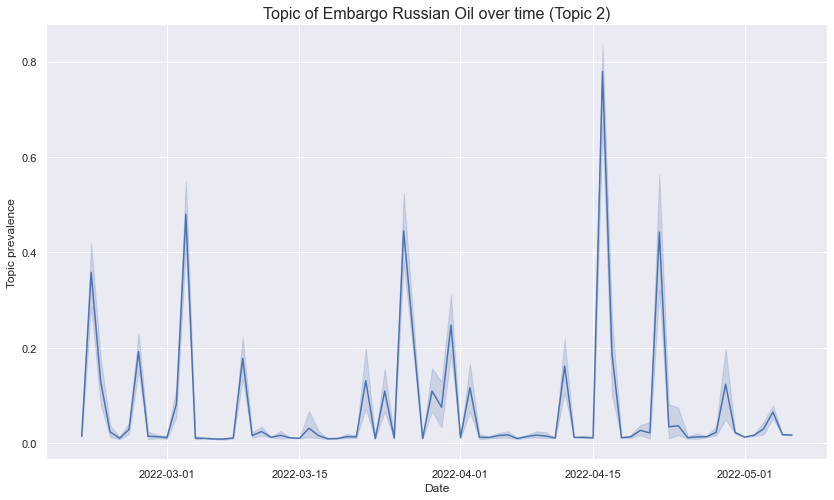

In [548]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['blue','red'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date_time', y = 'topic_1',  data = gamma_df, palette = palette)

plt.title('Topic of Embargo Russian Oil over time (Topic 2)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()

#So, the democrats were faster

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


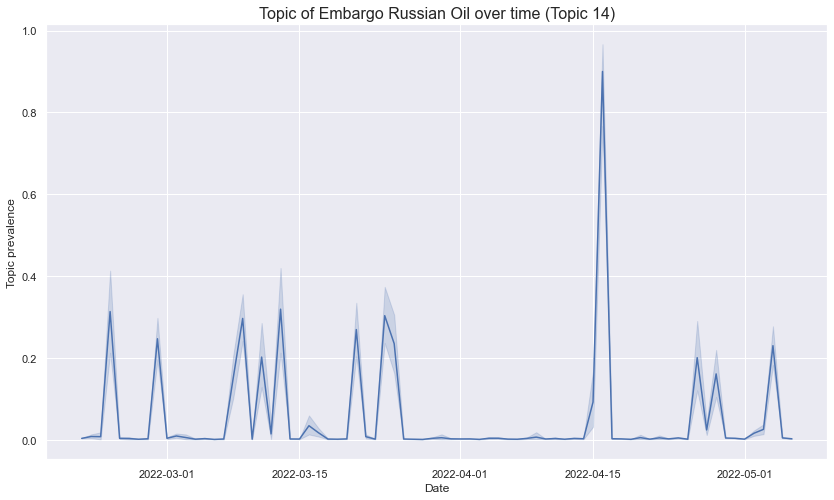

In [283]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['blue','red'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date_time', y = 'topic_1',  data = gamma_df, palette = palette)

plt.title('Topic of Opportunity over time (Topic 2)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()

#So, the democrats were faster

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


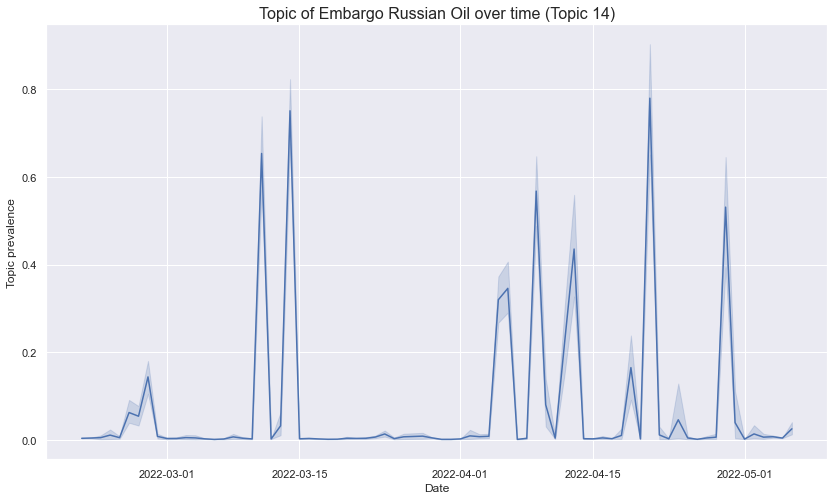

In [289]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['blue','red'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date_time', y = 'topic_7',  data = gamma_df, palette = palette)

plt.title('Topic of Orban / Ruble over time (Topic 14)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()

#So, the democrats were faster

/Users/morten/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


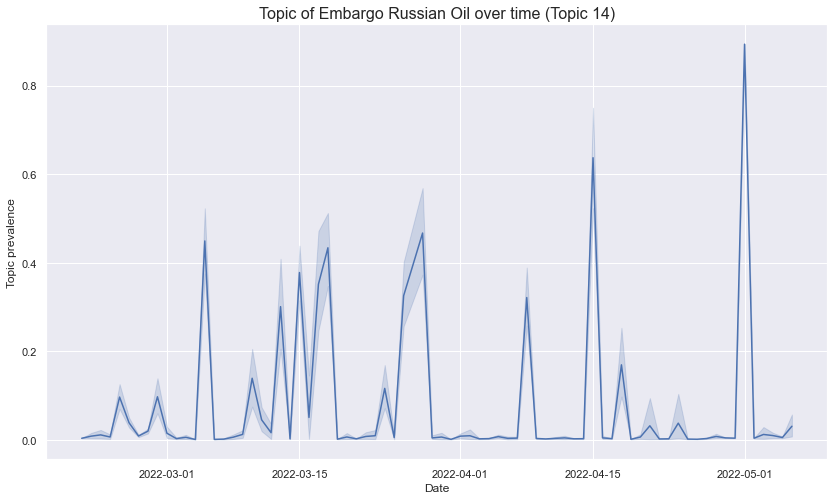

In [295]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['blue','red'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date_time', y = 'topic_12',  data = gamma_df, palette = palette)

plt.title('Topic of Embargo Russian Oil over time (Topic 14)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()

#So, the democrats were faster